# TREBALL DE FI DE GRAU

## ACCIDENTS DE TRÀNSIT: Predicció i factors de risc a través de models estadístics

### 1. INTRODUCCIÓ DEL TREBALL
#### 1.1 OBJECTIU
### 2. INTRODUCCIÓ A LA BASE DE DADES
####  2.1 LECTURA I GESTIÓ

In [1]:
# Llibreries necessàries
import pandas as pd
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import random
import imblearn
import warnings
from datetime import datetime
from scipy.stats import chi2_contingency
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

In [ ]:
# Importem les dades
dades = pd.read_csv('roadaccident.csv')
dades.head()

In [ ]:
dim = dades.shape
print(dim)

In [ ]:
# Recompte NA
warnings.simplefilter(action='ignore', category=FutureWarning)

recompte_NA = dades.isna().sum()
recompte_NA = pd.DataFrame({'VARIABLE': recompte_NA.index, 'NA': recompte_NA.values})

recompte_NA['% NA'] = (recompte_NA['NA'] / len(dades)) * 100   # percentatge (%)

plt.figure(figsize=(10, 6))
sns.barplot(x = 'VARIABLE', y = '% NA', data = recompte_NA, hue = 'VARIABLE', color = '#228B22', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('PERCENTATGE DE VALORS PERDUTS PER VARIABLE', fontsize = 15)
plt.ylabel('% NA', fontsize = 11)

for index, value in enumerate (recompte_NA['% NA']):
    plt.text(index, value, f'{round(value,3)}%', ha = 'center', va = 'bottom', 
             color = 'black', rotation = 0, fontsize = 8, weight = 'bold')
plt.savefig('NA.png', bbox_inches='tight')
plt.show()

In [ ]:
# Valors atípics 
dades_numeriques = dades[['Number_of_Casualties','Number_of_Vehicles','Speed_limit']]
columnes = dades_numeriques.columns
n = len(dades)

for i in columnes:
    Q1 = dades[i].quantile(0.25)
    Q3 = dades[i].quantile(0.75)
    
    Rang_Interquartilic = Q3 - Q1
    
    L_sup = Q3 + 1.5 * Rang_Interquartilic
    L_inf = Q1 - 1.5 * Rang_Interquartilic
    
    Valors_atipics = dades[(dades[i] < L_inf) | (dades[i] > L_sup)]
    Num_outliers = len(Valors_atipics)
    Percentatge_outliers = (Num_outliers*100)/n

    print('\n La quantitat de valors atípics de la variable',i ,f'és {Num_outliers}, que representa un {round(Percentatge_outliers,2)} % del total dels casos')

In [ ]:
# Casos duplicats
dades.duplicated().any()
duplicats = dades[dades.duplicated()]
num_duplicats = duplicats.shape[0]

# Eliminem casos duplicats
dades = dades.drop_duplicates()

In [ ]:
warnings.filterwarnings("ignore")

# Creem variables noves
dades['Accident Date'] = pd.to_datetime(dades['Accident Date'], format='%m/%d/%Y')
dades['Any_Accident'] = dades['Accident Date'].dt.year
dades['Mes_Accident'] = dades['Accident Date'].dt.month
dades['Dia_Accident'] = dades['Accident Date'].dt.day

# Eliminem variables que no utilitzarem
dades = dades.drop(columns = ['Accident_Index']) 
dades.head()

In [ ]:
# Comprovem de quina classe es cada una de les variables
dades.dtypes

**Analitzem totes les variables de la base de dades**

In [ ]:
# Accident Date
summary_Accident_Date = dades['Accident Date'].describe(datetime_is_numeric=True)

# Day_of_Week
dades['Day_of_Week'] = dades['Day_of_Week'].astype('category')
summary_Day_of_Week = dades['Day_of_Week'].describe()
classes_Day_of_Week = dades['Day_of_Week'].cat.categories
casos_per_classe_Day_of_Week = dades['Day_of_Week'].value_counts()
##print(casos_per_classe_Day_of_Week)

# Junction_Control
dades['Junction_Control'] = dades['Junction_Control'].astype('category')
summary_Junction_Control = dades['Junction_Control'].describe()
classes_Junction_Control = dades['Junction_Control'].cat.categories
casos_per_classe_Junction_Control = dades['Junction_Control'].value_counts()
##print(casos_per_classe_Junction_Control)

# Junction_Detail
dades['Junction_Detail'] = dades['Junction_Detail'].astype('category')
summary_Junction_Detail = dades['Junction_Detail'].describe()
classes_Junction_Detail = dades['Junction_Detail'].cat.categories
casos_per_classe_Junction_Detail = dades['Junction_Detail'].value_counts()
##print(casos_per_classe_Junction_Detail)

# Accident_Severity
dades['Accident_Severity'] = dades['Accident_Severity'].astype('category')
summary_Accident_Severity = dades['Accident_Severity'].describe()
classes_Accident_Severity = dades['Accident_Severity'].cat.categories
casos_per_classe_Accident_Severity = dades['Accident_Severity'].value_counts()
##print(casos_per_classe_Accident_Severity)

# Latitude
summary_Latitude = dades['Latitude'].describe()

# Light_Conditions
dades['Light_Conditions'] = dades['Light_Conditions'].astype('category')
summary_Light_Conditions = dades['Light_Conditions'].describe()
classes_Light_Conditions = dades['Light_Conditions'].cat.categories
casos_per_classe_Light_Conditions = dades['Light_Conditions'].value_counts()
##print(casos_per_classe_Light_Conditions)

# Local_Authority_(District)
dades['Local_Authority_(District)'] = dades['Local_Authority_(District)'].astype('category')
summary_Local_Authority_District = dades['Local_Authority_(District)'].describe()
classes_Local_Authority_District = dades['Local_Authority_(District)'].cat.categories
casos_per_classe_Local_Authority_District = dades['Local_Authority_(District)'].value_counts()
##print(casos_per_classe_Local_Authority_District)

# Carriageway_Hazards
dades['Carriageway_Hazards'] = dades['Carriageway_Hazards'].astype('category')
summary_Carriageway_Hazards = dades['Carriageway_Hazards'].describe()
classes_Carriageway_Hazards = dades['Carriageway_Hazards'].cat.categories
casos_per_classe_Carriageway_Hazards = dades['Carriageway_Hazards'].value_counts()
##print(casos_per_classe_Carriageway_Hazards)

# Longitude
summary_Longitude = dades['Longitude'].describe()

# Number_of_Casualties
summary_Number_of_Casualties = dades['Number_of_Casualties'].describe()
taula_freq_Number_of_Casualties = dades['Number_of_Casualties'].value_counts()

# Number_of_Vehicles
summary_Number_of_Vehicles = dades['Number_of_Vehicles'].describe()
taula_freq_Number_of_Vehicles = dades['Number_of_Vehicles'].value_counts()

# Police_Force
dades['Police_Force'] = dades['Police_Force'].astype('category')
summary_Police_Force = dades['Police_Force'].describe()
classes_Police_Force = dades['Police_Force'].cat.categories
casos_per_classe_Police_Force = dades['Police_Force'].value_counts()
##print(casos_per_classe_Police_Force)

# Road_Surface_Conditions
dades['Road_Surface_Conditions'] = dades['Road_Surface_Conditions'].astype('category')
summary_Road_Surface_Conditions = dades['Road_Surface_Conditions'].describe()
classes_Road_Surface_Conditions = dades['Road_Surface_Conditions'].cat.categories
casos_per_classe_Road_Surface_Conditions = dades['Road_Surface_Conditions'].value_counts()
##print(casos_per_classe_Road_Surface_Conditions)

# Road_Type
dades['Road_Type'] = dades['Road_Type'].astype('category')
summary_Road_Type = dades['Road_Type'].describe()
classes_Road_Type = dades['Road_Type'].cat.categories
casos_per_classe_Road_Type = dades['Road_Type'].value_counts()
##print(casos_per_classe_Road_Type)

# Speed_limit
summary_Speed_limit = dades['Speed_limit'].describe()
taula_freq_Speed_limit = dades['Speed_limit'].value_counts()

# Time
dades['Time'] = dades['Time'].astype('category')
summary_Time = dades['Time'].describe()
classes_Time = dades['Time'].cat.categories
casos_per_classe_Time = dades['Time'].value_counts()
##print(casos_per_classe_Time)

# Urban_or_Rural_Area
dades['Urban_or_Rural_Area'] = dades['Urban_or_Rural_Area'].astype('category')
summary_Urban_or_Rural_Area = dades['Urban_or_Rural_Area'].describe()
classes_Urban_or_Rural_Area = dades['Urban_or_Rural_Area'].cat.categories
casos_per_classe_Urban_or_Rural_Area = dades['Urban_or_Rural_Area'].value_counts()
##print(casos_per_classe_Urban_or_Rural_Area)

# Weather_Conditions 
dades['Weather_Conditions'] = dades['Weather_Conditions'].astype('category')
summary_Weather_Conditions = dades['Weather_Conditions'].describe()
classes_Weather_Conditions = dades['Weather_Conditions'].cat.categories
casos_per_classe_Weather_Conditions = dades['Weather_Conditions'].value_counts()
##print(casos_per_classe_Weather_Conditions)

# Vehicle_Type
dades['Vehicle_Type'] = dades['Vehicle_Type'].astype('category')
summary_Vehicle_Type = dades['Vehicle_Type'].describe()
classes_Vehicle_Type = dades['Vehicle_Type'].cat.categories
casos_per_classe_Vehicle_Type = dades['Vehicle_Type'].value_counts()
##print(casos_per_classe_Vehicle_Type)

# Any_Accident
dades['Any_Accident'] = dades['Any_Accident'].astype('category')
summary_Any_Accident = dades['Any_Accident'].describe()
classes_Any_Accident = dades['Any_Accident'].cat.categories
casos_per_classe_Any_Accident = dades['Any_Accident'].value_counts()
##print(casos_per_classe_Any_Accident)

# Month_Accident
summary_Mes_Accident = dades['Mes_Accident'].describe()
taula_freq_Mes_Accident = dades['Mes_Accident'].value_counts()

In [ ]:
# Comprovem que s'han passat de tipus object a categòric
dades.dtypes

### 3. ANÀLISI DESCRIPTIVA
#### ANÀLISI DESCRIPTIVA QUANTITATIVA

Alguns gràfics previs a realitzar canvis en algunes variables

In [ ]:
# Univariant

# Number_of_Casualties
frequencia_casualties = dades['Number_of_Casualties'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_casualties.index, frequencia_casualties.values, color = '#008000')
plt.xlim(0, max(frequencia_casualties.index) + 1)
plt.xlabel('Number of Casualties')
plt.ylabel('Freqüència')
plt.title('FREQÜÈNCIA D\'ACCIDENTS PER NOMBRE DE VÍCTIMES', fontsize = 15)
for i, v in zip(frequencia_casualties.index, frequencia_casualties.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize=6)
#plt.savefig('gqt_casualties_1.png', bbox_inches='tight')
plt.show()


# Number_of_Vehicles
frequencia_vehicles = dades['Number_of_Vehicles'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_vehicles.index, frequencia_vehicles.values, color = '#008000', width = 0.8)
plt.xlim(0, max(frequencia_vehicles.index) + 1)
plt.xlabel('Number of Vehicles')
plt.ylabel('Freqüència')
plt.title('FREQÜÈNCIA D\'ACCIDENTS PER NOMBRE DE VEHICLES', fontsize = 15)
for i, v in zip(frequencia_vehicles.index, frequencia_vehicles.values):
    plt.text(i , v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize=6)
#plt.savefig('gqt_NumVehicles_1.png', bbox_inches='tight')
plt.show()


# Speed_Limit
frequencia_velocitat = dades['Speed_limit'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_velocitat.index, frequencia_velocitat.values, color = '#008000', width = 4)
plt.xlabel('Speed Limit')
plt.ylabel('Freqüència')
plt.title('FREQÜÈNCIA D\'ACCIDENTS DELS DIFERENTS LÍMITS DE VELOCITAT', fontsize = 15)
for i, v in zip(frequencia_velocitat.index, frequencia_velocitat.values):
    plt.text(i , v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize=6)
#plt.savefig('gqt_SpeedLimit_1.png', bbox_inches='tight')
plt.show()

# Mes_Accident
x = ['Gener','Febrer','Març','Abril','Maig','Juny','Juliol',' Agost', 'Setembre','Octubre', 'Novembre', 'Desembre']
frequencia_mes = dades['Mes_Accident'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_mes.index, frequencia_mes.values, color = '#008000', width = 0.9)
plt.xlabel('Mes Accident')
plt.ylabel('Freqüència')
plt.title('FREQÜÈNCIA D\'ACCIDENTS PER MES', fontsize = 15)
plt.xticks(ticks = range(1, len(x) + 1), labels = x, rotation = 90, fontsize = 8)
#plt.savefig('gq_MesAccidentt.png', bbox_inches='tight')
plt.show()

# Dia_Accident
x = list(range(1,32))
frequencia_dia = dades['Dia_Accident'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_dia.index, frequencia_dia.values, color = '#008000', width = 0.9)
plt.xlabel('Dia Accident')
plt.ylabel('Freqüència')
plt.title('FREQÜÈNCIA D\'ACCIDENTS PER DIA', fontsize = 15)
plt.xticks(ticks = range(1, len(x) + 1), labels = x, rotation = 90, fontsize = 8)
#plt.savefig('gq_DiaAccidentt.png', bbox_inches='tight')
plt.show()

# UNIVARIANT - QUALITATIVA

# Vehicle_Type
frequencia_vehicletype = dades['Vehicle_Type'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_vehicletype.index, frequencia_vehicletype.values, color = '#008000', width = 0.9)
plt.xlabel('Vehicle Type')
plt.ylabel('Freqüència')
plt.title('FREQÜÈNCIA D\'ACCIDENTS DELS DIFERENTS TIPUS DE VEHICLES', fontsize = 15)
plt.xticks(rotation=90, fontsize=8)
for i, v in zip(frequencia_vehicletype.index, frequencia_vehicletype.values):
    plt.text(i , v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize=7)
#plt.savefig('gq_TypeVehicle_1.png', bbox_inches='tight')
plt.show()

In [ ]:
# Bivariant

# Gràfic disperssió Speed Limit i Number of Casualties
plt.figure(figsize=(10, 8))
plt.scatter(dades['Speed_limit'], dades['Number_of_Casualties'],color = '#008000')
plt.yticks(range(0, max(dades['Number_of_Casualties']) + 1, 5))

plt.xlabel('Speed Limit')
plt.ylabel('Number of Casualties')
plt.title('RELACIÓ ENTRE EL LÍMIT DE VELOCITAT I EL NOMBRE DE VÍCTIMES EN ELS ACCIDENTS', fontsize = 15)
#plt.savefig('gqtqt_SpeedCasualties_2.png', bbox_inches='tight')
plt.show()

correlation1 = np.corrcoef(dades['Speed_limit'], dades['Number_of_Casualties'])[0, 1]

# Gràfic disperssió Number of vehicles i Number of Casualties
plt.figure(figsize=(10, 8))
plt.scatter(dades['Number_of_Vehicles'], dades['Number_of_Casualties'],color = '#008000')
plt.yticks(range(0, max(dades['Number_of_Casualties']) + 1, 5))

plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Casualties')
plt.title('RELACIÓ ENTRE EL NOMBRE DE VEHICLES I EL NOMBRE DE VÍCTIMES EN ELS ACCIDENTS', fontsize = 15)
#plt.savefig('gqtqt_NumVehiclesCasualties_2.png', bbox_inches='tight')
plt.show()

correlation2 = np.corrcoef(dades['Number_of_Vehicles'], dades['Number_of_Casualties'])[0, 1]

**Apliquem les modificacions necessàries:**

- Accident Severity: Passar fetal a fatal (error ortogràfic)
- Junction_Control: Passar 'Auto traffic sigl' a 'Auto traffic signal' (error ortogràfic)
- Number_of_Casualities: posar >=4 com a nova categoria en comptes de (4,5,6,7,8,9...)
- Number_of_Vehicles: posar >=4 com a nova categoria en comptes de (4,5,6,7,8,9...)

In [ ]:
# Accident_Severity - error ortogràfic
dades['Accident_Severity'] = dades['Accident_Severity'].replace('Fetal','Fatal') 

# Junction_Control - error ortogràfic
dades['Junction_Control'] = dades['Junction_Control'].replace('Auto traffic sigl',
                                                              'Auto traffic signal')

# Number_of_Casualties
dades['Number_of_Casualties'] = pd.Categorical(dades['Number_of_Casualties'], ordered=True)

if '4 o més' not in dades['Number_of_Casualties'].cat.categories:
    dades['Number_of_Casualties'] = dades['Number_of_Casualties'].cat.add_categories('4 o més')
    
dades.loc[dades['Number_of_Casualties'] >= 4, 'Number_of_Casualties'] = '4 o més'

categoria_a_eliminar = [42,43,48,40,19,21,22,24,26,27,13,14,15,16,17,18,12,11,10,9,8,7,6,4,5]
categories_presents = dades['Number_of_Casualties'].cat.categories
categories_a_eliminar2 = [categoria for categoria in categoria_a_eliminar if categoria in categories_presents]

if categories_a_eliminar2:
    dades['Number_of_Casualties'] = dades['Number_of_Casualties'].cat.remove_categories(categories_a_eliminar2)

# Number_of_Vehicles
dades['Number_of_Vehicles'] = pd.Categorical(dades['Number_of_Vehicles'], ordered=True)

if '4 o més' not in dades['Number_of_Vehicles'].cat.categories:
    dades['Number_of_Vehicles'] = dades['Number_of_Vehicles'].cat.add_categories('4 o més')
    
dades.loc[dades['Number_of_Vehicles'] >=4, 'Number_of_Vehicles'] = "4 o més"

categoria_a_eliminar2 = [4,5,6,7,8,9,10,11,12,13,14,16,19,32]
categories_presents2 = dades['Number_of_Vehicles'].cat.categories
categories_a_eliminar22 = [categoria for categoria in categoria_a_eliminar2 if categoria in categories_presents2]

if categories_a_eliminar22:
    dades['Number_of_Vehicles'] = dades['Number_of_Vehicles'].cat.remove_categories(categories_a_eliminar22)
    
# Speed_Limit
dades['Speed_limit'] = dades['Speed_limit'].astype('category')
categories_a_eliminar3 = [10,15]
dades['Speed_limit'] = dades['Speed_limit'].cat.remove_categories(categories_a_eliminar3)


# Vehicle_Type
dades['Vehicle_Type'] = pd.Categorical(dades['Vehicle_Type'], ordered=True)

dades.loc[dades['Vehicle_Type'] == "Pedal cycle", 'Vehicle_Type'] = "Other vehicle"
dades.loc[dades['Vehicle_Type'] == "Ridden horse", 'Vehicle_Type'] = "Other vehicle"

categoria_a_eliminar3 = ["Pedal cycle", "Ridden horse"]
categories_presents3 = dades['Vehicle_Type'].cat.categories
categories_a_eliminar33 = [categoria for categoria in categoria_a_eliminar3 if categoria in categories_presents3]

if categories_a_eliminar33:
    dades['Vehicle_Type'] = dades["Vehicle_Type"].cat.remove_categories(categories_a_eliminar33)
    
# Light_Conditions
dades['Light_Conditions'] = pd.Categorical(dades['Light_Conditions'], ordered=True)

dades.loc[dades['Light_Conditions'] == "Darkness - lights unlit", 'Light_Conditions'] = "Darkness - no lighting"

categoria_a_eliminar4 = ["Darkness - lights unlit"]
categories_presents4 = dades['Light_Conditions'].cat.categories
categories_a_eliminar44 = [categoria for categoria in categoria_a_eliminar4 if categoria in categories_presents4]

if categories_a_eliminar44:
    dades['Light_Conditions'] = pd.Categorical(dades['Light_Conditions'].cat.remove_categories(categories_a_eliminar44))


Gràfics després d'aplicar les modificacions:

In [ ]:
# Univariant

# Number_of_Casualties
categories = ['1', '2', '3', '4 o més']
frequencia_casualties = dades['Number_of_Casualties'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(categories, frequencia_casualties, color = '#008000')
plt.xlabel('Number of Casualties', fontsize = 16)
plt.ylabel('Freqüència', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('FREQÜÈNCIA D\'ACCIDENTS PER NOMBRE DE VÍCTIMES', fontsize = 17)
for i, v in zip(categories, frequencia_casualties):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize = 14)
#plt.savefig('gqt_casualties_2.png', bbox_inches='tight')
plt.show()

# Number_of_Vehicles
categories = ['1', '2', '3', '4 o més']
frequencia_vehicles = dades['Number_of_Vehicles'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(categories, frequencia_vehicles, color = '#008000', width = 0.8)
plt.xlabel('Number of Vehicles', fontsize = 16)
plt.ylabel('Freqüència', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('FREQÜÈNCIA D\'ACCIDENTS PER NOMBRE DE VEHÍCLES', fontsize = 17)
for i, v in zip(categories, frequencia_vehicles):
    plt.text(i , v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize = 14)
#plt.savefig('gqt_NumVehicles_2.png', bbox_inches='tight')
plt.show()

# Speed_Limit
dades = dades.dropna(subset = ['Speed_limit'])
frequencia_velocitat = dades['Speed_limit'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_velocitat.index, frequencia_velocitat.values, color = '#008000', width = 4)
plt.xlabel('Speed Limit', fontsize = 15)
plt.ylabel('Freqüència', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FREQÜÈNCIA D\'ACCIDENTS DELS DIFERENTS LÍMITS DE VELOCITAT', fontsize = 15)
for i, v in zip(frequencia_velocitat.index, frequencia_velocitat.values):
    plt.text(i , v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize = 14)
#plt.savefig('gqt_SpeedLimit_2.png', bbox_inches='tight')
plt.show()

# Any_Accident
frequencia_any = dades['Any_Accident'].value_counts().sort_index()
plt.figure(figsize=(8, 8))
plt.pie(frequencia_any, labels=frequencia_any.index, autopct='%1.1f%%', 
        textprops={'fontsize': 14, 'color': 'white'}, startangle=90, 
        colors=['#008000', '#DAA520'])
plt.legend(labels=frequencia_any.index, title='Year', loc='upper right', fontsize = 15, title_fontsize = 17)
plt.title('FREQÜÈNCIA D\'ACCIDENTS PER ANY', fontsize = 15)
#plt.savefig('gqt_YearAccident_2.png', bbox_inches='tight')
plt.show()

In [ ]:
# Bivariant (1)

## Speed Limit + Number of Casualties 

### Barres Longitud Iguals
cross_table = pd.crosstab(dades['Speed_limit'],dades['Number_of_Casualties'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)
cross_table.plot(kind='bar', color = ['#008000', '#DAA520', '#FF0000', '#5F9EA0'], stacked=True, figsize=(9, 7))

plt.legend(title='Number of Casualties', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Speed Limit", fontsize = 11)
plt.yticks(fontsize = 11)
plt.xticks(fontsize = 11)
plt.title('PROPORCIÓ DEL NOMBRE DE VÍCTIMES EN ELS DIFERENTS LÍMITS DE VELOCITAT', fontsize = 15)
#plt.savefig('gqtqt_SpeedCasualties_1.png', bbox_inches='tight')
plt.show()

### Diagrama de violí
dades_new = dades.copy()

speed_limit_order = sorted(dades_new['Speed_limit'].unique())
dades_new['Speed_limit_numeric'] = pd.to_numeric(dades_new['Speed_limit'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.violinplot(x=dades_new['Number_of_Casualties'], y=dades_new['Speed_limit_numeric'], 
               scale="width", palette= ['#008000', '#DAA520', '#FF0000', '#5F9EA0'])
plt.yticks(speed_limit_order, fontsize = 15)
plt.xticks(ticks=[0, 1, 2, 3], labels=['1', '2', '3', '4 o més'], fontsize=15)
plt.xlabel('Number of Casualties', fontsize =  15)
plt.ylabel('Speed Limit', fontsize = 15)
plt.title('GRÀFIC DE VIOLÍ DEL LÍMIT DE VELOCITAT SEGONS\nEL NOMBRE DE VÍCTIMES', fontsize = 17)
#plt.savefig('gqtqt_SpeedCasualties3.png', bbox_inches='tight')
plt.show()

### BoxPlot
plt.figure(figsize=(10, 8))
sns.boxplot(x=dades_new['Number_of_Casualties'], y=dades_new['Speed_limit_numeric'], 
            palette= ['#008000', '#DAA520', '#FF0000', '#5F9EA0'])
plt.yticks(speed_limit_order)
plt.xlabel('Number of Casualties', fontsize = 16)
plt.ylabel('Speed Limit', fontsize = 16)
plt.title('GRÀFIC DE CAIXES DEL LÍMIT DE VELOCITAT SEGONS EL NOMBRE DE VÍCTIMES', fontsize = 17)
plt.xticks(ticks=[0, 1, 2, 3], labels=['1', '2', '3', '4 o més'], fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('gqtqt_SpeedCasualties_boxplot.png', bbox_inches='tight')
plt.show()

In [ ]:
# Bivariant (2)

## Road Surface Conditions i Speed limit
dades['Speed_limit'] = pd.to_numeric(dades['Speed_limit'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.boxplot(x='Road_Surface_Conditions', y='Speed_limit', data=dades, color = "#008000")
plt.xlabel('Road Surface Conditions')
plt.ylabel('Speed Limit')
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.title('ANÀLISI DELS LÍMITS DE VELOCITAT EN DIFERENTS CONDICIONS DE LA SUPERFÍCIE DE LA CARRETERA', fontsize = 15)
#plt.savefig('gqtql_SurfaceSpeed.png', bbox_inches='tight')
plt.show()

## Accident_Severity i Speed limit

### Boxplot
dades['Speed_limit'] = pd.to_numeric(dades['Speed_limit'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.boxplot(x='Accident_Severity', y='Speed_limit', data=dades, palette=["red","orange","green"])
plt.xlabel('Accident_Severity')
plt.ylabel('Speed Limit')
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.title('ANÀLISI DELS LÍMITS DE VELOCITAT EN DIFERENTS GRAUS DE GRAVETAT DELS ACCIDENTS', fontsize = 15)
#plt.savefig('gqtql_RespSpeed_1.png', bbox_inches='tight')
plt.show()

### Diagrama de violí
dades['Speed_limit'] = pd.to_numeric(dades['Speed_limit'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.violinplot(x='Accident_Severity', y='Speed_limit', data=dades, palette=["red","orange","green"])
plt.xlabel('Accident Severity', fontsize = 16)
plt.ylabel('Speed Limit', fontsize = 16)
plt.title('DISTRIBUCIÓ DELS LÍMITS DE VELOCITAT SEGONS\nLA GRAVETAT DELS ACCIDENTS', fontsize = 17)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.savefig('gqtql_RespSpeed_2.png', bbox_inches='tight')
plt.show()


## Accident_Severity i Number_of_Casualties
dades['Number_of_Casualties'] = pd.Categorical(dades['Number_of_Casualties'], ordered=True)

if '4' not in dades['Number_of_Casualties'].cat.categories:
    dades['Number_of_Casualties'] = dades['Number_of_Casualties'].cat.add_categories('4')
    
dades.loc[dades['Number_of_Casualties'] == "4 o més", 'Number_of_Casualties'] = '4'

categoria_a_eliminar = ["4 o més"]
categories_presents = dades['Number_of_Casualties'].cat.categories
categories_a_eliminar2 = [categoria for categoria in categoria_a_eliminar if categoria in categories_presents]

if categories_a_eliminar2:
    dades['Number_of_Casualties'] = dades['Number_of_Casualties'].cat.remove_categories(categories_a_eliminar2)

dades['Number_of_Casualties'] = pd.to_numeric(dades['Number_of_Casualties'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.violinplot(x='Accident_Severity', y='Number_of_Casualties', data=dades, palette=["red","orange","green"])
plt.xlabel('Accident Severity')
plt.ylabel('Number_of_Casualties')
plt.title('DISTRIBUTION OF NUMBER OF CASUALTIES ACROSS ACCIDENT SEVERITY', fontsize = 15)
#plt.savefig('gqtql_RespCasualties_1.png', bbox_inches='tight')
plt.show()

## Accident_Severity i Number_of_Vehicles

dades['Number_of_Vehicles'] = pd.Categorical(dades['Number_of_Vehicles'], ordered=True)

if '4' not in dades['Number_of_Vehicles'].cat.categories:
    dades['Number_of_Vehicles'] = dades['Number_of_Vehicles'].cat.add_categories('4')
    
dades.loc[dades['Number_of_Vehicles'] == "4 o més", 'Number_of_Vehicles'] = "4"

categoria_a_eliminar2 = ["4 o més"]
categories_presents2 = dades['Number_of_Vehicles'].cat.categories
categories_a_eliminar22 = [categoria for categoria in categoria_a_eliminar2 if categoria in categories_presents2]

if categories_a_eliminar22:
    dades['Number_of_Vehicles'] = dades['Number_of_Vehicles'].cat.remove_categories(categories_a_eliminar22)

dades['Number_of_Vehicles'] = pd.to_numeric(dades['Number_of_Vehicles'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.violinplot(x='Accident_Severity', y='Number_of_Vehicles', data=dades, palette=["red","orange","green"])
plt.xlabel('Accident Severity')
plt.ylabel('Number_of_Vehicles')
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.title('DISTRIBUCIÓ DEL NOMBRE DE VEHICLES SEGONS LA GRAVETAT DELS ACCIDENTS', fontsize = 15)
#plt.savefig('gqtql_RespNumVehicles_1.png', bbox_inches='tight')
plt.show()

### Boxplot
dades['Number_of_Vehicles'] = pd.to_numeric(dades['Number_of_Vehicles'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.boxplot(x='Accident_Severity', y='Number_of_Vehicles', data=dades, palette=["red","orange","green"])
plt.xlabel('Accident Severity')
plt.ylabel('Number of Vehicles')
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.title('DISTRIBUCIÓ DEL NOMBRE DE VEHICLES SEGONS LA GRAVETAT DELS ACCIDENTS', fontsize = 15)
#plt.savefig('gqtql_RespNumVehicles_1.png', bbox_inches='tight')
plt.show()

## Accident_Severity i Mes_Accident 

dades['Mes_Accident'] = pd.to_numeric(dades['Mes_Accident'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.boxplot(x='Accident_Severity', y='Mes_Accident', data=dades, palette=["red","orange","green"])
plt.xlabel('Accident_Severity')
plt.ylabel('Month')
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.title('DISTRIBUCIÓ DEL MES DELS ACCIDENTS SEGONS LA DIFERENT GRAVETAT DELS ACCIDENTS', fontsize = 15)
#plt.savefig('gqtql_RespMonth_1.png', bbox_inches='tight')
plt.show()

In [ ]:
# Violin plots discretitzats - hue = Any_Accident

dades['Speed_limit'] = pd.to_numeric(dades['Speed_limit'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.violinplot(x='Accident_Severity', y='Speed_limit', data=dades, hue = 'Any_Accident', 
               palette=["orange","red"], split=True)
plt.xlabel('Accident Severity', fontsize = 23)
plt.ylabel('Speed Limit', fontsize = 23)
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
plt.title('LÍMITS DE VELOCITAT SEGONS LA GRAVETAT DELS\nACCIDENTS PER ANY', fontsize = 25, pad = 80)
plt.legend(title = 'Any',loc='upper center', bbox_to_anchor=(0.5, 1.18), fontsize = 21, title_fontsize = 21, ncol = 2)
#plt.savefig('violin3_RespSpeedYear.png', bbox_inches='tight')
plt.show()

dades['Number_of_Casualties'] = pd.to_numeric(dades['Number_of_Casualties'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.violinplot(x='Accident_Severity', y='Number_of_Casualties', data=dades, hue = 'Any_Accident', 
               palette=["orange","red"], split = True)
plt.xlabel('Accident Severity')
plt.ylabel('Number_of_Casualties')
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.title('DISTRIBUCIÓ DEL NOMBRE DE VÍCTIMES SEGONS LA GRAVETAT DELS ACCIDENTS', fontsize = 15)
plt.legend(title='Accident Year',loc='upper right', bbox_to_anchor=(1.15, 1))
#plt.savefig('violin3_RespCasualtiesYear.png', bbox_inches='tight')
plt.show()

dades['Number_of_Vehicles'] = pd.to_numeric(dades['Number_of_Vehicles'], errors='coerce')

plt.figure(figsize=(10, 8))
sns.violinplot(x='Accident_Severity', y='Number_of_Vehicles', data=dades, hue = "Any_Accident", 
               palette=["orange","red"], split=True)
plt.xlabel('Accident Severity')
plt.ylabel('Number_of_Vehicles')
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.title('DISTRIBUCIÓ DEL NOMBRE DE VEHICLES SEGONS LA GRAVETAT DELS ACCIDENTS', fontsize = 15)
plt.legend(title='Accident Year',loc='upper right', bbox_to_anchor=(1.15, 1))
#plt.savefig('violin3_RespNumVehiclesYear.png', bbox_inches='tight')
plt.show()

In [ ]:
# Violin plots discretitzats - hue = Number_of_casualties

dades_new['NumberCasualties2'] = dades['Number_of_Casualties'].apply(lambda x: "1" if x == 1 else "Més de 1")

plt.figure(figsize=(10, 8))
sns.violinplot(x='Accident_Severity', y='Speed_limit', data=dades_new, hue='NumberCasualties2', 
               palette = ["orange","red"], split=True)
plt.title('LÍMITS DE VELOCITAT SEGONS LA GRAVETAT DELS\nACCIDENTS PER NOMBRE DE VÍCTIMES', fontsize = 25, pad = 85)
plt.xlabel('Accident Severity', fontsize = 23)
plt.ylabel('Speed limit', fontsize = 23)
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
plt.gca().invert_yaxis()
plt.legend(title='Number of Casualties',loc='upper center', bbox_to_anchor=(0.5, 1.18), fontsize = 21, title_fontsize = 21, ncol = 2)
#plt.savefig('violin3_RespSpeedCasualt_1.png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(10, 8))
dades_new['Number_of_Vehicles'] = dades_new['Number_of_Vehicles'].replace('4 o més', 4)
sns.violinplot(x='Accident_Severity', y='Number_of_Vehicles', data=dades_new, hue = "NumberCasualties2", 
               palette=["orange","red"], split=True)
plt.xlabel('Accident Severity', fontsize = 23)
plt.ylabel('Number_of_Vehicles', fontsize = 23)
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
plt.gca().invert_yaxis()
plt.title('NOMBRE DE VEHICLES SEGONS LA GRAVETAT DELS ACCIDENTS\nPER NOMBRE DE VÍCTIMES', fontsize = 15)
plt.legend(title='Number of Casualties',loc='upper right', bbox_to_anchor=(1.5, 1), fontsize = 23, title_fontsize = 23)
#plt.savefig('gqtql_RespNumVehicles_1.png', bbox_inches='tight')
plt.show()

In [ ]:
# Series temporals

mesos = {
    1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31
}

mitjanes_per_mes_total = {}

classes = {
    'Fatal': 'Fatal',
    'Serious': 'Serious',
    'Slight': 'Slight'
}

for i, cond in classes.items():
    df = dades[dades['Accident_Severity'] == cond]
    
    mitjanes_per_mes = []
    
    for any_accident in [2021, 2022]:
        df_any = df[df['Any_Accident'] == any_accident]
        
        for mes in range(1, 13):
            df_mes = df_any[df_any['Mes_Accident'] == mes]
            
            num_dies = mesos[mes]
            mitjana_casos = len(df_mes) / num_dies
            
            mitjanes_per_mes.append(mitjana_casos)
            
    mitjanes_per_mes_total[i] = mitjanes_per_mes
    
mitjanes_per_mes_fatal = mitjanes_per_mes_total['Fatal']
mitjanes_per_mes_serious = mitjanes_per_mes_total['Serious']
mitjanes_per_mes_slight = mitjanes_per_mes_total['Slight']

In [ ]:
# FATAL
fatal_data = dades[dades['Accident_Severity'] == 'Fatal']
monthly_means = pd.DataFrame(mitjanes_per_mes_fatal, columns=['Mean Fatal Accidents'])

monthly_index = pd.date_range(start='2021-01-01', periods=len(monthly_means), freq='M')
monthly_means.index = monthly_index - pd.offsets.MonthEnd()

daily_counts = fatal_data.groupby('Accident Date').size()

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='', color='gray', label='Fatal Accidents per Day')
plt.plot(monthly_means.index, monthly_means['Mean Fatal Accidents'], marker='o', color='red', 
         linestyle='-', label='Monthly Mean Fatal Accidents')
first_day_of_each_month = [pd.Timestamp(year, month, 1) for year in range(2021, 2023) for month in range(1, 13)]

plt.xticks(first_day_of_each_month, rotation=90, fontsize = 14)
plt.yticks(fontsize = 13)
plt.xlabel('')
plt.ylabel('Accidents Fatals', fontsize = 15)
plt.title('EVOLUCIÓ DIÀRIA D\'ACCIDENTS MORTALS AMB MITJANA MENSUAL', fontsize=17)
plt.legend(loc='upper right', fontsize = 14, title_fontsize = 14)
plt.ylim(0,20)
plt.savefig('gqtql_TendenciaFatal_1.png', bbox_inches='tight')

plt.show()

# SERIOUS
serious_data = dades[dades['Accident_Severity'] == 'Serious']
monthly_means = pd.DataFrame(mitjanes_per_mes_serious, columns=['Mean Serious Accidents'])

monthly_index = pd.date_range(start='2021-01-01', periods=len(monthly_means), freq='M')
monthly_means.index = monthly_index - pd.offsets.MonthEnd()

daily_counts = serious_data.groupby('Accident Date').size()

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='', color='gray', label='Serious Accidents per Day')
plt.plot(monthly_means.index, monthly_means['Mean Serious Accidents'], marker='o', color='darkorange', 
         linestyle='-', label='Monthly Mean Serious Accidents')

first_day_of_each_month = [pd.Timestamp(year, month, 1) for year in range(2021, 2023) for month in range(1, 13)]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(first_day_of_each_month, rotation=90, fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel('')
plt.ylabel('Accidents Greus', fontsize = 15)
plt.title('EVOLUCIÓ DIÀRIA D\'ACCIDENTS GREUS AMB MITJANA MENSUAL', fontsize=17)
plt.legend(loc='upper right', fontsize = 14, title_fontsize = 14)


extended_start_date = monthly_index[0] - pd.DateOffset(months=2)
extended_end_date = monthly_index[-1] + pd.DateOffset(months=1)
plt.xlim(extended_start_date, extended_end_date) 
plt.ylim(0,100)
plt.savefig('gqtql_TendenciaSerious_1.png', bbox_inches='tight')

plt.show()

# SLIGHT
slight_data = dades[dades['Accident_Severity'] == 'Slight']
monthly_means = pd.DataFrame(mitjanes_per_mes_slight, columns=['Mean Slight Accidents'])

monthly_index = pd.date_range(start='2021-01-01', periods=len(monthly_means), freq='M')
monthly_means.index = monthly_index - pd.offsets.MonthEnd()

daily_counts = slight_data.groupby('Accident Date').size()

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='', color='gray', label='Slight Accidents per Day')
plt.plot(monthly_means.index, monthly_means['Mean Slight Accidents'], marker='o', color='green', 
         linestyle='-', label='Monthly Mean Slight Accidents')
first_day_of_each_month = [pd.Timestamp(year, month, 1) for year in range(2021, 2023) for month in range(1, 13)]

plt.xticks(first_day_of_each_month, [date.strftime('%Y-%m-%d') for date in first_day_of_each_month], rotation=90, fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel('')
plt.ylabel('Accidents Lleus', fontsize = 15)
plt.title('EVOLUCIÓ DIÀRIA D\'ACCIDENTS LLEUS AMB MITJANA MENSUAL', fontsize=17)
plt.legend(loc='upper right', fontsize = 14, title_fontsize = 14)

extended_start_date = monthly_index[0] - pd.DateOffset(months=2)
extended_end_date = monthly_index[-1] + pd.DateOffset(months=1)
plt.xlim(extended_start_date, extended_end_date) 
plt.ylim(0,650)
plt.savefig('gqtql_TendenciaSlight_1.png', bbox_inches='tight')

plt.show()

In [ ]:
# (Fatal + Serious + Slight)
daily_counts = dades.groupby([dades['Accident Date'].dt.year, dades['Accident Date'].dt.month, dades['Accident Date'].dt.day, 'Accident_Severity']).size().unstack()
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='', color=['red', 'orange', 'green'])

plt.xlabel('Data')
plt.ylabel('Accidents')
plt.title('EVOLUCIÓ DE LA GRAVETAT DELS ACCIDENTS AL LARG DEL TEMPS')
plt.legend(title='Accident Severity', loc='upper right', bbox_to_anchor=(1.4, 1))
plt.xticks(rotation=90, fontsize = 9)
plt.yticks(fontsize = 9)

plt.show()

#### **ANÀLISI DESCRIPTIVA QUALITATIVA**


In [ ]:
# Univariant

# Accident_Severity 
frequencia_accident_sev = dades['Accident_Severity'].value_counts().sort_index()
colors = ['red','orange','green']
start_angles = 40
plt.pie(frequencia_accident_sev.values, labels=frequencia_accident_sev.index, autopct='%1.1f%%',
        startangle=start_angles, textprops={'fontsize': 12, 'color': 'white'}, labeldistance=None, colors=colors)
plt.title('FREQÜÈNCIA DE LA GRAVETAT DELS ACCIDENTS', fontsize = 15)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), prop={'size': 12})
#plt.savefig('gq_resp_1')
plt.show()

# Weather_Conditions
frequencia_weather = dades['Weather_Conditions'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_weather.index, frequencia_weather.values, color = '#008000', width = 0.9)
plt.xlabel('Weather Conditions', fontsize = 11)
plt.ylabel('Freqüència', fontsize = 11)
plt.title('FREQÜÈNCIA D\'ACCIDENTS PER LES DIFERENTS CONDICIONS CLIMÀTIQUES', fontsize = 15)
plt.xticks(rotation=60, fontsize=11)
plt.yticks(fontsize = 11)
for i, v in zip(frequencia_weather.index, frequencia_weather.values):
    plt.text(i , v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize=8)
#plt.savefig('gq_weather_1.png', bbox_inches='tight')
plt.show()

# Light_Conditions
frequencia_light = dades['Light_Conditions'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_light.index, frequencia_light.values, color = '#008000', width = 0.9)
plt.xlabel('Light Conditions', fontsize = 11)
plt.ylabel('Freqüència', fontsize = 11)
plt.title('FREQÜÈNCIA D\'ACCIDENTS PER LES DIFERENTS CONDICIONS DE LLUM', fontsize = 15)
plt.xticks(rotation=0, fontsize = 8)
plt.yticks(fontsize = 11)
for i, v in zip(frequencia_light.index, frequencia_light.values):
    plt.text(i , v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize=8)
#plt.savefig('gq_light_1')
plt.show()

# Local_Authority_(District)
top_20_districts = dades['Local_Authority_(District)'].value_counts().nlargest(20)

percentatges = (top_20_districts / top_20_districts.sum()) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(top_20_districts.index, percentatges, color='#008000', width=0.9)
plt.xlabel('20 principals autoritats locals', fontsize = 11)
plt.ylabel('Percentatge (%)')
plt.title('DISTRIBUCIÓ PERCENTUAL DE LES 20 PRINCIPALS ENTITATS LOCALS')
plt.xticks(rotation=60, fontsize=8)
for bar, percentage in zip(bars, percentatges):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, 
             f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=7)
#plt.savefig('gq_district_1')
plt.show()

# Vehicle_Type
frequencia_vehicletype = dades['Vehicle_Type'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(frequencia_vehicletype.index, frequencia_vehicletype.values, color = '#008000', width = 0.9)
plt.xlabel('Vehicle Type')
plt.ylabel('Freqüència')
plt.title('FREQÜÈNCIA D\'ACCIDENTS PELS DIFERENTS TIPUS DE VEHICLES', fontsize = 15)
plt.xticks(rotation=90, fontsize=8)
for i, v in zip(frequencia_vehicletype.index, frequencia_vehicletype.values):
    plt.text(i , v + 0.1, str(v), ha='center', va='bottom', color='black', fontsize=7)
#plt.savefig('gq_vehicle_1')
plt.show()

In [ ]:
# Bivariant

# Accident_Severity i Day_of_Week
cross_table = pd.crosstab(dades['Day_of_Week'], dades['Accident_Severity'])
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cross_table = cross_table.reindex(order_days)
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 15, title_fontsize = 15)
plt.xlabel('Day of Week', fontsize=15)
plt.xticks(rotation = 0, fontsize=15)
plt.yticks(fontsize = 15)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS\nI FREQÜÈNCIA PER DIA', fontsize = 17)

ax2 = ax.twinx()
frequencies = dades['Day_of_Week'].value_counts().reindex(order_days)
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(loc='upper right', bbox_to_anchor=(1.55, 0.7), fontsize = 15)

#plt.savefig('gqq_RespDay_2.png', bbox_inches='tight')
plt.show()

# Accident_Severity i Road_Surface_Conditions
cross_table = pd.crosstab(dades['Road_Surface_Conditions'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Road_Surface_Conditions'].value_counts()
frequencies = frequencies.reindex(cross_table.index) 

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.2, 0.6), loc='upper left', fontsize = 15, title_fontsize = 15)
plt.xlabel('Road Surface Conditions', fontsize=14)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Dry', 'Flood over 3cm', 'Frost or ice', 'Snow', 'Wet or damp'], 
           fontsize=14, rotation = 0)
plt.yticks(fontsize = 14)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I\nFREQÜÈNCIA PER CONDICIONS DE SUPERFÍCIE', fontsize=17)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 15)

#plt.savefig('gqq_RespSurface_2.png', bbox_inches='tight')
plt.show()

# Accident_Severity i Weather_Conditions
cross_table = pd.crosstab(dades['Weather_Conditions'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Weather_Conditions'].value_counts()
frequencies = frequencies.reindex(cross_table.index)

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 14, title_fontsize = 14)
plt.xlabel('Weather Conditions', fontsize=14)
plt.xticks(fontsize=12)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I FREQÜÈNCIA PER CONDICIONS CLIMÀTIQUES', fontsize = 15)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 14)

#plt.savefig('gqq_RespWeather_2.png', bbox_inches='tight')
plt.show()

# Accident_Severity i Urban or Rural Area
cross_table = pd.crosstab(dades['Urban_or_Rural_Area'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Urban_or_Rural_Area'].value_counts()
frequencies = frequencies.reindex(cross_table.index)

fig, ax = plt.subplots(figsize = (10, 6))
cross_table.plot(kind = 'bar', stacked = True, color = ['red', 'orange', 'green'], ax = ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 15, title_fontsize = 15)
plt.xlabel('Urban_or_Rural_Area', fontsize = 15)
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I\nFREQÜÈNCIA PER ÀREES', fontsize = 17)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 15)

#plt.savefig('gqq_RespUrbRur_2.png', bbox_inches='tight')
plt.show()

# Accident_Severity i Road Type
cross_table = pd.crosstab(dades['Road_Type'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Road_Type'].value_counts()
frequencies = frequencies.reindex(cross_table.index)

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 14, title_fontsize = 14)
plt.xlabel('Road_Type', fontsize=14)
plt.xticks(rotation = 0, fontsize=12)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I FREQÜÈNCIA PER TIPUS DE CARRETERA', fontsize = 15)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 14)

#plt.savefig('gqq_RespRoad_2.png', bbox_inches='tight')
plt.show()

# Accident_Severity i Vehicle Type
cross_table = pd.crosstab(dades['Vehicle_Type'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Vehicle_Type'].value_counts()
frequencies = frequencies.reindex(cross_table.index)

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 14, title_fontsize = 14)
plt.xlabel('Vehicle_Type', fontsize=14)
plt.xticks(fontsize=12)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I FREQÜÈNCIA PER TIPUS DE VEHÍCLE', fontsize = 15)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 14)

#plt.savefig('gqq_RespVehicle_2.png', bbox_inches='tight')
plt.show()

# Accident_Severity i Junction_Control
cross_table = pd.crosstab(dades['Junction_Control'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Junction_Control'].value_counts()
frequencies = frequencies.reindex(cross_table.index)

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 14, title_fontsize = 14)
plt.xlabel('Junction Control', fontsize=14)
plt.xticks(fontsize=12)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I FREQÜÈNCIA PER TIPUS DE REGULACIÓ EN L\'ENCREUAMENT', fontsize = 15)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 14)

#plt.savefig('gqq_RespJControl_2.png', bbox_inches='tight')
plt.show()


# Accident_Severity i Junction_Detail
cross_table = pd.crosstab(dades['Junction_Detail'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Junction_Detail'].value_counts()
frequencies = frequencies.reindex(cross_table.index)

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 14, title_fontsize = 14)
plt.xlabel('Junction Detail', fontsize=14)
plt.xticks(fontsize=12)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I FREQÜÈNCIA PER TIPUS D\'ENCREUAMENT', fontsize = 15)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 14)

#plt.savefig('gqq_RespJDetail_2.png', bbox_inches='tight')
plt.show()


# Accident_Severity i Light_Conditions
cross_table = pd.crosstab(dades['Light_Conditions'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Light_Conditions'].value_counts()
frequencies = frequencies.reindex(cross_table.index)

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 14, title_fontsize = 14)
plt.xlabel('Light Conditions', fontsize = 13)
plt.xticks(rotation = 0, fontsize=11)
plt.yticks(fontsize = 13)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I\nFREQÜÈNCIA PER DIFERENTS CONDICIONS DE LLUM', fontsize = 17)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.tick_params(axis='y', labelsize=13)
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 14)

#plt.savefig('gqq_RespLight_2.png', bbox_inches='tight')
plt.show()


# Accident_Severity i Carriageway_Hazards
cross_table = pd.crosstab(dades['Carriageway_Hazards'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Carriageway_Hazards'].value_counts()
frequencies = frequencies.reindex(cross_table.index)

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 14, title_fontsize = 14)
plt.xlabel('Carriageway Hazards', fontsize=14)
plt.xticks(fontsize=12)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I FREQÜÈNCIA PER DIFERENTS PERILLS EN LA CALÇADA', fontsize = 15)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 14)

#plt.savefig('gqq_RespCarriage_2.png', bbox_inches='tight')
plt.show()


# Accident_Severity i Police_Force
cross_table = pd.crosstab(dades['Police_Force'], dades['Accident_Severity'])
cross_table = cross_table.div(cross_table.sum(axis=1), axis=0)

frequencies = dades['Police_Force'].value_counts()
frequencies = frequencies.reindex(cross_table.index)

fig, ax = plt.subplots(figsize=(10, 6))
cross_table.plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

plt.legend(title='Accident Severity', bbox_to_anchor=(1.15, 0.6), loc='upper left', fontsize = 14, title_fontsize = 14)
plt.xlabel('Police Force', fontsize=14)
plt.xticks(fontsize=12)
plt.title('PROPORCIÓ DE LA GRAVETAT DELS ACCIDENTS I FREQÜÈNCIA PER LES DIFERENTS FORCES POLICIALS', fontsize = 15)

ax2 = ax.twinx()
ax2.plot(frequencies.index, frequencies.values, color='black', linestyle='-', marker='o', label='Freqüència d\'accidents')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 0.7), fontsize = 14)

#plt.savefig('gqq_RespPolice_2.png', bbox_inches='tight')
plt.show()

#### **ANÀLISI DESCRIPTIVA MULTIVARIANT**

In [ ]:
# Freqüències relatives (FATAL)
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

dades_serious = dades[dades['Accident_Severity'] == 'Fatal']
total_accidents_serious = len(dades_serious)

freq_relatives = dades_serious.groupby(['Latitude', 'Longitude']).size() / total_accidents_serious
freq_relatives = freq_relatives.reset_index(name='Freqüència relativa')

escalem = MinMaxScaler()
freq_relatives[['Freqüència relativa']] = escalem.fit_transform(freq_relatives[['Freqüència relativa']])

df = pd.DataFrame({
    'latitude': freq_relatives['Latitude'],
    'longitude': freq_relatives['Longitude'],
    'F. Rel': freq_relatives['Freqüència relativa']
})

fig = px.density_mapbox(df, lat='latitude', lon='longitude', z='F. Rel',
                        radius=20,
                        center=dict(lat=min(df.latitude), lon=min(df.longitude)),
                        zoom=6,
                        mapbox_style='open-street-map',
                        height=1000,
                        width=1000)

fig.update_layout(
    coloraxis_colorbar=dict(
        title='F. Rel',  
        titlefont=dict(size=35, color='black'),  
        tickfont=dict(size=35, color='black') 
    )
)
fig.show()

In [ ]:
# Freqüències relatives (SERIOUS)
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

dades_serious = dades[dades['Accident_Severity'] == 'Serious']
total_accidents_serious = len(dades_serious)

freq_relatives = dades_serious.groupby(['Latitude', 'Longitude']).size() / total_accidents_serious
freq_relatives = freq_relatives.reset_index(name='Freqüència relativa')

escalem = MinMaxScaler()
freq_relatives[['Freqüència relativa']] = escalem.fit_transform(freq_relatives[['Freqüència relativa']])

df = pd.DataFrame({
    'latitude': freq_relatives['Latitude'],
    'longitude': freq_relatives['Longitude'],
    'F. Rel': freq_relatives['Freqüència relativa']
})

fig = px.density_mapbox(df, lat='latitude', lon='longitude', z='F. Rel',
                        radius=12,
                        center=dict(lat=min(df.latitude), lon=min(df.longitude)),
                        zoom=6,
                        mapbox_style='open-street-map',
                        height=1000,
                        width=1000)

fig.update_layout(
    coloraxis_colorbar=dict(
        title='F. Rel',  
        titlefont=dict(size=35, color='black'),  
        tickfont=dict(size=35, color='black') 
    )
)
fig.show()

In [ ]:
# Freqüències relatives (SLIGHT)
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

dades_slight = dades[dades['Accident_Severity'] == 'Slight']
total_accidents_slight = len(dades_slight)

freq_relatives = dades_slight.groupby(['Latitude', 'Longitude']).size() / total_accidents_slight
freq_relatives = freq_relatives.reset_index(name='Freqüència relativa')

escalem = MinMaxScaler()
freq_relatives[['Freqüència relativa']] = escalem.fit_transform(freq_relatives[['Freqüència relativa']])

df = pd.DataFrame({
    'latitude': freq_relatives['Latitude'],
    'longitude': freq_relatives['Longitude'],
    'F. Rel': freq_relatives['Freqüència relativa']
})

fig = px.density_mapbox(df, lat='latitude', lon='longitude', z='F. Rel',
                        radius=12,
                        center=dict(lat=min(df.latitude), lon=min(df.longitude)),
                        zoom=6,
                        mapbox_style='open-street-map',
                        height=1000,
                        width=1000)

fig.update_layout(
    coloraxis_colorbar=dict(
        title='F. Rel',  
        titlefont=dict(size=35, color='black'),  
        tickfont=dict(size=35, color='black') 
    )
)
fig.show()

#### **CORRELACIONS I ASSOOCIACIONS ENTRE VARIABLES**

In [ ]:
# Matriu de correlacions (Variables numèriques)
cmap = sns.diverging_palette(10, 150, s=100, l=45, sep=5, as_cmap=True,)

variables_quantitatives = ['Latitude', 'Longitude','Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit']
matriu_correlacions = dades[variables_quantitatives].corr()

plt.figure(figsize=(12, 10))
cmap_custom = sns.color_palette("Greens", as_cmap=True)
heatmap = sns.heatmap(matriu_correlacions, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5, center=0,  
                      annot_kws={"fontsize":12})

for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    spine.set_color('white')

heatmap.set_title('MATRIU DE CORRELACIONS', fontsize = 15)
plt.xticks(rotation=90, fontsize=11)
plt.yticks(rotation=0, fontsize=11)

#plt.savefig('CorrNumeriques.png', bbox_inches='tight')
plt.show()

In [ ]:
# TRIANGLE SUPERIOR
cmap = sns.diverging_palette(10, 150, s=100, l=45, sep=5, as_cmap=True,)

variables_quantitatives = ['Latitude', 'Longitude','Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit', 'Any_Accident']
matriu_correlacions = dades[variables_quantitatives].corr()
triangle_superior_correlacions = matriu_correlacions.where(np.triu(np.ones(matriu_correlacions.shape), k = 0).astype(bool))

plt.figure(figsize=(12, 10))
cmap_custom = sns.color_palette("RdYlGn", as_cmap=True)
heatmap = sns.heatmap(triangle_superior_correlacions, annot = True, cmap = cmap_custom, fmt=".2f", linewidths = 0.5, 
                      center = 0,  annot_kws = {"fontsize":20})

for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    spine.set_color('white')

heatmap.set_title('MATRIU DE CORRELACIONS', fontsize = 24)
plt.xticks(rotation = 90, fontsize = 21)
plt.yticks(rotation = 0, fontsize = 21)
plt.savefig('CorrNumeriques2.png', bbox_inches='tight')
plt.show()

In [ ]:
# TRIANGLE SUPERIOR
cmap = sns.diverging_palette(10, 150, s=100, l=45, sep=5, as_cmap=True,)

variables_quantitatives = ['Latitude', 'Longitude','Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit', 'Any_Accident']
matriu_correlacions = dades[variables_quantitatives].corr()
triangle_superior_correlacions = matriu_correlacions.where(np.triu(np.ones(matriu_correlacions.shape), k = 0).astype(bool))

plt.figure(figsize=(12, 10))
cmap_custom = sns.color_palette("Greens", as_cmap=True)
heatmap = sns.heatmap(triangle_superior_correlacions, annot = True, cmap = cmap, fmt=".2f", linewidths = 0.5, 
                      center = 0,  annot_kws = {"fontsize":20})

for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    spine.set_color('white')

heatmap.set_title('MATRIU DE CORRELACIONS', fontsize = 24)
plt.xticks(rotation = 90, fontsize = 21)
plt.yticks(rotation = 0, fontsize = 21)
#plt.savefig('CorrNumeriques.png', bbox_inches='tight')
plt.show()

In [ ]:
# V Cramer - Associacions entre variables
dades_qualitatives = dades[["Day_of_Week", "Junction_Control", "Junction_Detail", "Accident_Severity", "Light_Conditions", 
                            "Carriageway_Hazards", "Police_Force", "Road_Surface_Conditions", "Road_Type", 
                           "Urban_or_Rural_Area","Weather_Conditions", "Vehicle_Type","Local_Authority_(District)"]]

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    k = max(contingency_table.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

n_variables = len(dades_qualitatives.columns)
cramer_matrix = np.eye(n_variables)

for i in range(n_variables):
    for j in range(i + 1, n_variables):
        v_cramer = cramers_v(dades_qualitatives.iloc[:, i], dades_qualitatives.iloc[:, j])
        cramer_matrix[i, j] = v_cramer
        cramer_matrix[j, i] = v_cramer  

#cmap_custom = sns.color_palette("Greens", as_cmap=True)
cmap_custom = sns.diverging_palette(10, 150, as_cmap=True, s=100, l=45, sep=5)

plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap=cmap_custom, center=0, fmt=".2f", linewidths=0.5, vmin=0, vmax=1)

plt.title('V DE CRAMER - ASSOCIACIÓ ENTRE VARIABLES CATEGÒRIQUES', fontsize = 15)
plt.xticks(np.arange(n_variables) + 0.5, dades_qualitatives.columns, rotation=90, fontsize=11)
plt.yticks(np.arange(n_variables) + 0.5, dades_qualitatives.columns, rotation=0, fontsize=11)

#plt.savefig('AssociCategoriques.png', bbox_inches='tight')
plt.show()

In [ ]:
# TRIANGLE SUPERIOR
dades_qualitatives = dades[["Day_of_Week", "Junction_Control", "Junction_Detail", "Accident_Severity", "Light_Conditions", 
                            "Carriageway_Hazards", "Police_Force", "Road_Surface_Conditions", "Road_Type", 
                           "Urban_or_Rural_Area","Weather_Conditions", "Vehicle_Type","Local_Authority_(District)"]]

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    k = max(contingency_table.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

n_variables = len(dades_qualitatives.columns)
matriu_cramer = np.eye(n_variables)

for i in range(n_variables):
    for j in range(i + 1, n_variables):
        v_cramer = cramers_v(dades_qualitatives.iloc[:, i], dades_qualitatives.iloc[:, j])
        matriu_cramer[i, j] = v_cramer
        matriu_cramer[j, i] = v_cramer  

triangle_superior_vcramer = pd.DataFrame(matriu_cramer).where(np.triu(np.ones(matriu_cramer.shape), k = 0).astype(bool))
cmap_custom = sns.diverging_palette(10, 150, as_cmap=True, s=100, l=45, sep=5)

plt.figure(figsize=(10, 8))
sns.heatmap(triangle_superior_vcramer, annot=True, cmap=cmap_custom, center=0, fmt=".2f", linewidths=0.5, vmin=0, vmax=1)

plt.title('V DE CRAMER - ASSOCIACIÓ ENTRE VARIABLES CATEGÒRIQUES', fontsize = 17)
plt.xticks(np.arange(n_variables) + 0.5, dades_qualitatives.columns, rotation=90, fontsize=14)
plt.yticks(np.arange(n_variables) + 0.5, dades_qualitatives.columns, rotation=0, fontsize=14)
plt.savefig('AssociCategoriques.png', bbox_inches='tight')
plt.show()

In [ ]:
dades_qualitatives = dades[["Day_of_Week", "Junction_Control", "Junction_Detail", "Accident_Severity", "Light_Conditions", 
                            "Carriageway_Hazards", "Police_Force", "Road_Surface_Conditions", "Road_Type", 
                           "Urban_or_Rural_Area","Weather_Conditions", "Vehicle_Type","Local_Authority_(District)"]]

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    k = max(contingency_table.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

n_variables = len(dades_qualitatives.columns)
matriu_cramer = np.eye(n_variables)

for i in range(n_variables):
    for j in range(i + 1, n_variables):
        v_cramer = cramers_v(dades_qualitatives.iloc[:, i], dades_qualitatives.iloc[:, j])
        matriu_cramer[i, j] = v_cramer
        matriu_cramer[j, i] = v_cramer  

cmap_custom = sns.color_palette("RdYlGn", as_cmap=True)

plt.figure(figsize=(10, 8))
sns.heatmap(triangle_superior_vcramer, annot=True, cmap=cmap_custom, center=0, fmt=".2f", linewidths=0.5, vmin=0, vmax=1)

plt.title('V DE CRAMER - ASSOCIACIÓ ENTRE VARIABLES CATEGÒRIQUES', fontsize = 17)
plt.xticks(np.arange(n_variables) + 0.5, dades_qualitatives.columns, rotation=90, fontsize=14)
plt.yticks(np.arange(n_variables) + 0.5, dades_qualitatives.columns, rotation=0, fontsize=14)
plt.savefig('AssociCategoriques2.png', bbox_inches='tight')
plt.show()

### 4.  MODELS PREDICTIUS
#### **TRACTAMENT DELS VALORS PERDUTS (NA)**

**Variables amb NA**

- Carriageway_Hazards
- Road_Surface_Conditions
- Road_Type
- Time
- Wheather_Conditions

In [ ]:
# Time - imputació
## darkness - no lighting
from statistics import mode
darknessnolight = dades[dades['Light_Conditions'] == "Darkness - no lighting"].copy()
darknessnolight['Time'] = pd.to_datetime(darknessnolight['Time'], format='%H:%M')
mode_temps_dark_nolight = mode(darknessnolight['Time'])
mode_temps_dark_nolight = mode_temps_dark_nolight.strftime('%H:%M')

filtre1 = (pd.isnull(dades['Time'])) & (dades['Light_Conditions'] == 'Darkness - no lighting')
dades.loc[filtre1, 'Time'] = mode_temps_dark_nolight

## daylight
daylight = dades[dades['Light_Conditions'] == "Daylight"].copy()
daylight['Time'] = pd.to_datetime(daylight['Time'], format='%H:%M')
mediana_temps_daylight = daylight['Time'].mean()
mediana_temps_daylight = mediana_temps_daylight.strftime('%H:%M')

filtre2 = (pd.isnull(dades['Time'])) & (dades['Light_Conditions'] == 'Daylight')
dades.loc[filtre2, 'Time'] = mediana_temps_daylight

## darkness- lights lit
darknesslightslit = dades[dades['Light_Conditions'] == "Darkness - lights lit"].copy()
darknesslightslit['Time'] = pd.to_datetime(darknesslightslit['Time'], format='%H:%M')
mode_temps_darknesslightslit = mode(darknesslightslit['Time'])
mode_temps_darknesslightslit = mode_temps_darknesslightslit.strftime('%H:%M')

filtre3 = (pd.isnull(dades['Time'])) & (dades['Light_Conditions'] == 'Darkness - lights lit')
dades.loc[filtre3, 'Time'] = mode_temps_darknesslightslit

In [ ]:
# Creem nova variable - Moment_Dia
dades['Time'] = pd.to_datetime(dades['Time'])

filtre1 = (dades['Time'].dt.hour >= 6) & (dades['Time'].dt.hour <= 11) & (dades['Time'].dt.minute <= 59)
filtre2 = (dades['Time'].dt.hour >= 12) & (dades['Time'].dt.hour <= 14) & (dades['Time'].dt.minute <= 59)
filtre3 = (dades['Time'].dt.hour >= 15) & (dades['Time'].dt.hour <= 19) & (dades['Time'].dt.minute <= 59)
filtre4 = (dades['Time'].dt.hour >= 20) & (dades['Time'].dt.hour <= 23) & (dades['Time'].dt.minute <= 59)
filtre5 = (dades['Time'].dt.hour >= 0) & (dades['Time'].dt.hour <= 5) & (dades['Time'].dt.minute <= 59)

dades.loc[filtre1, 'Moment_Dia'] = 'Matí'
dades.loc[filtre2, 'Moment_Dia'] = 'Migdia'
dades.loc[filtre3, 'Moment_Dia'] = 'Tarda'
dades.loc[filtre4, 'Moment_Dia'] = 'Nit'
dades.loc[filtre5, 'Moment_Dia'] = 'Matinada'

categorias = ['Matí', 'Migdia', 'Tarda', 'Nit', 'Matinada']
moment_dia_dtype = pd.CategoricalDtype(categories=categorias)

dades['Moment_Dia'] = dades['Moment_Dia'].astype(moment_dia_dtype)

# Eliminem variable Time
dades = dades.drop(columns = ['Time','Accident Date'])

In [ ]:
# Carriage_Hazards - Eliminem (3 NA)
dades = dades.dropna(subset = ['Carriageway_Hazards'])

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# DUMMIES
# dummies variables amb pocs nivells
dades_dummies = dades.drop(['Local_Authority_(District)','Police_Force'],axis=1)
dades_dummies = pd.get_dummies(dades_dummies, dummy_na=False)

# dummies variable Local Authority District
dades_dummies1 = dades.loc[:, ["Local_Authority_(District)"]]
frequencies_LocalAuthority = dades['Local_Authority_(District)'].value_counts()
x = 2500
classes_menys_frequents1 =  frequencies_LocalAuthority[frequencies_LocalAuthority < x].index
dades_dummies1 = dades_dummies1.replace(classes_menys_frequents1, 'Altres')
dades_dummies1 = pd.get_dummies(dades_dummies1)

# dummies variable Police Force
dades_dummies2 = dades.loc[:, ["Police_Force"]]
frequencies_PoliceForce = dades['Police_Force'].value_counts()
x = 9500
classes_menys_frequents2 =  frequencies_PoliceForce[frequencies_PoliceForce < x].index
dades_dummies2 = dades_dummies2.replace(classes_menys_frequents2, 'Altres')
dades_dummies2 = pd.get_dummies(dades_dummies2)

dades_dummies = pd.concat([dades_dummies, dades_dummies1], axis = 1)
dades_dummies = pd.concat([dades_dummies, dades_dummies2], axis = 1)

In [ ]:
# Transformem 0 en NA (variables "Road_Type", "Road_Surface_Conditions" i "Weather_Conditions")
selected_columns1 = [col for col in dades_dummies.columns if col.startswith("Road_Type")]

for index, row in dades_dummies.iterrows():
    if row[selected_columns1].sum() == 0:
        dades_dummies.loc[index, selected_columns1] = pd.NA
        
selected_columns2 = [col for col in dades_dummies.columns if col.startswith("Road_Surface_Conditions")]

for index, row in dades_dummies.iterrows():
    if row[selected_columns2].sum() == 0:
        dades_dummies.loc[index, selected_columns2] = pd.NA
        
selected_columns3 = [col for col in dades_dummies.columns if col.startswith("Weather_Conditions")]

for index, row in dades_dummies.iterrows():
    if row[selected_columns3].sum() == 0:
        dades_dummies.loc[index, selected_columns3] = pd.NA

#dades_dummies.to_csv('dades_dummies2.csv', index=False)

In [ ]:
# Imputació NA
dades_dummies2 = pd.read_csv('dades_dummies2.csv')
imputer = KNNImputer(n_neighbors = 5)  # per defecte: strategy = mean
dades_imputades = pd.DataFrame(imputer.fit_transform(dades_dummies2), columns = dades_dummies2.columns)

#dades_imputades.to_csv('dades_imputades.csv', index=False) 

In [ ]:
# Comprovem NA
dades_imputades = pd.read_csv('dades_imputades.csv')
dades_imputades.isna().sum().sum()

In [ ]:
# 1: a les variables dummies on hi hagi el màxim, 0: les altres i en cas d'empat aleatòriament
dades_imputades = pd.read_csv('dades_imputades.csv')
categories = ["Road_Type", "Road_Surface_Conditions", "Weather_Conditions"]

for categoria in categories:
    col = dades_imputades.filter(regex=f'^{categoria}', axis=1).columns
    
    for index, row in dades_imputades.iterrows():
        files_val = row[col]
        valor_max = files_val.max()
        cont_max = (files_val == valor_max).sum()
        
        if cont_max > 1:
            indexs_max = files_val[files_val == valor_max].index.tolist()
            index_max = np.random.choice(indexs_max)
        else:
            max_index = files_val.idxmax()
        
        dades_imputades.loc[index, col] = 0
        dades_imputades.at[index, max_index] = 1

In [ ]:
# ELIMINAR
plt.figure(figsize=(30,30))
correlacions = dades_imputades.corr()
cmap_custom = sns.diverging_palette(10, 150, as_cmap=True, s=100, l=45, sep=5)
sns.heatmap(correlacions , annot=False, cmap=cmap_custom, center=0, fmt=".2f", linewidths=0.5, vmin=0, vmax=1)

plt.title('MAPA DE CALOR DE CORRELACIONS ENTRE LES VARIABLES', fontsize = 15)
plt.show()

In [ ]:
# Reconvertim dummies en variables categòriques

warnings.simplefilter(action='ignore', category=FutureWarning) # ignorem warnings


patrons_prefixos = {
    'Day_of_Week': ('^Day_of_Week_', ''),
    'Junction_Control': ('^Junction_Control_', ''),
    'Junction_Detail': ('^Junction_Detail_', ''),
    'Accident_Severity': ('^Accident_Severity_', ''),
    'Light_Conditions': ('^Light_Conditions_', ''),
    'Carriageway_Hazards': ('^Carriageway_Hazards_', ''),
    'Road_Surface_Conditions': ('^Road_Surface_Conditions_', ''),
    'Road_Type': ('^Road_Type_', ''),
    'Urban_or_Rural_Area': ('^Urban_or_Rural_Area_', ''),
    'Weather_Conditions': ('^Weather_Conditions_', ''),
    'Vehicle_Type': ('^Vehicle_Type_', ''),
    'Any_Accident': ('^Any_Accident_', ''),
    'Moment_Dia': ('^Moment_Dia_', ''),
    'Local_Authority_District': ('^Local_Authority_\(District\)_', ''),
    'Police_Force': ('^Police_Force_', '')
    
    
}

dades2 = pd.DataFrame()

for i, (patro, prefix) in patrons_prefixos.items():
    variables = dades_imputades.filter(regex = patro, axis = 1)
    categories = variables.idxmax(axis=1)
    categories = categories.str.replace(patro, "")

    dades2[i] = categories

dades2 = pd.concat([dades2, dades_imputades[['Latitude','Longitude','Number_of_Casualties','Number_of_Vehicles',
                                       'Speed_limit','Mes_Accident','Dia_Accident']]], axis=1)
        
#dades2.to_csv('dades2.csv', index=False)

#### SELECCIÓ DE VARIABLES I TÈCNICA SMOTE

In [2]:
dades2 = pd.read_csv('dades2.csv') 

# Convertim les variables de tipus object a categòriques
for var in dades2.columns:
    if dades2[var].dtype == 'object':
        dades2[var] = dades2[var].astype('category')

**Tècnica SMOTE** 

In [3]:
# Convertim les variables categòriques a Dummy (menys la variable resposta)
no_dummy = dades2['Accident_Severity']
si_dummies = dades2.drop('Accident_Severity', axis=1)  
columnes_dummies = pd.get_dummies(si_dummies)
dades_dummies2 = pd.concat([no_dummy, columnes_dummies], axis=1)

le = LabelEncoder()
dades_dummies2['Accident_Severity'] = le.fit_transform(dades2['Accident_Severity']) #0: Fatal, 1: Serious, 2: Slight

X = dades_dummies2.drop(['Accident_Severity'], axis=1)
y = dades_dummies2['Accident_Severity']

smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X, y)

dades_equilibrades = pd.DataFrame(X_resampled, columns=X.columns)
dades_equilibrades['Accident_Severity'] = y_resampled

dades_equilibrades.to_csv('dades_equilibrades.csv', index=False)
dades_equilibrades = pd.read_csv('dades_equilibrades.csv') 

In [ ]:
# Accident_Severity - Dades balancejades
frequencia_accident_sev = dades_equilibrades['Accident_Severity'].value_counts().sort_index()
colors = ['red','orange','green']
start_angles = 90
plt.pie(frequencia_accident_sev.values, labels = ['Fatal', 'Serious', 'Slight'], autopct='%1.1f%%',
        startangle=start_angles, textprops={'fontsize': 12, 'color': 'white'}, labeldistance=None, colors=colors)
plt.title('FREQÜÈNCIA DE LA GRAVETAT DELS ACCIDENTS', fontsize = 15)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), prop={'size': 12})
plt.savefig('gq_resp_2')
plt.show()

Per seguir amb la selecció de variables he realitzat dues proves diferents:

- Per les variables numèriques s'ha utilitzat el mètode de l'anàlisi de variància (ANOVA). Ens retorna les variables numèriques ordenades de manera descendentment segons les seves puntuacions F en ANOVA.
- Per les variables categòriques s'ha utilitzat la prova de chi-quadrat. Ens retorna les variables categòriques més rellevants mitjançant la prova chi-quadrat, ens les retorna ordenades descendentment.


A més a més, a continuació utilitzarem proves estadístiques univariables com la prova F o la prova chi-quadrat per evaluar la relació entre cada variable (tant numèrica con categòrica) i la variable resposta. I a partir dels resultats mencionats anteriorment i els obtinguts a continuació decidirem quines seran les variables que utlitzarem per realitzar els nostres models predictius.

In [ ]:
# variables numèriques (DADES DESBALANCEJADES)
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = dades2.drop('Accident_Severity', axis=1) 
y = dades2['Accident_Severity'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

X_train_numeric = X_train.select_dtypes(include='number')

k = 3 

selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train_numeric, y_train)

scores = selector.scores_ # prova F
variables_scores = pd.DataFrame({'Variable': X_train_numeric.columns, 'Score': scores}) # creem data frame  
sorted_variables = variables_scores.sort_values(by='Score', ascending=False) # ordenem descendentment
sorted_variables_names = sorted_variables['Variable'].values # obtenim els noms de les variables ordenades descendentment segons F

print(sorted_variables)

In [ ]:
# variables categòriques (DADES DESBALANCEJADES)

X_train_categorical = X_train.select_dtypes(include=['object', 'category'])
X_train_encoded = pd.get_dummies(X_train_categorical)

k = 4  

selector = SelectKBest(score_func=chi2, k=k)
X_train_selected = selector.fit_transform(X_train_encoded, y_train)

indexs = selector.get_support(indices=True) # obtenim indexs característiques seleccionades
variables = X_train_encoded.columns[indexs] # obtenim noms de les característiques

chi2_scores = selector.scores_ # obtenim valors prova chi-quadrat
variables_chi2_scores = pd.DataFrame({'Variable': X_train_encoded.columns, 'Chi2 Score': chi2_scores}) # creem df
sorted_variable_chi2_scores = variables_chi2_scores.sort_values(by='Chi2 Score', ascending=False) # ordenem descendentment
sorted_variable_names = sorted_variable_chi2_scores['Variable'].values # ordenem els noms 

pd.set_option('display.max_rows', None)
print(variables_chi2_scores)

In [ ]:
filtre = ["Day_of_Week_","Light_Conditions_","Carriageway_Hazards_","Road_Surface_Conditions_",
          "Road_Type_","Urban_or_Rural_Area_","Weather_Conditions_","Moment_Dia_","Police_Force_",
                              "Junction_Detail_","Junction_Control_","Local_Authority_District_",
                              "Vehicle_Type_"]

chi_quadrat_resultats = {}

for i in filtre:
    filtered_rows = variables_chi2_scores[variables_chi2_scores['Variable'].str.startswith(i)]
    valors = filtered_rows['Chi2 Score'].tolist()
    
    if valors:
        chi_quadrat_resultats[i] = sum(valors) / len(valors)
    else:
        chi_quadrat_resultats[i] = 0


print("Mitjana del valor Chi2 Score per variable:")
for grup, mean in chi_quadrat_resultats.items():
    print(f"'{grup}': {mean}")
        

A continuació tornarem a utilizar l'anàlisi de la variancia (ANOVA) per calcular la importancia de les característiques en relació amb la variable resposta en problemes de classificació, però en aquest cas amb les **dades balancejades**.

In [ ]:
# VARIABLES NUMÈRIQUES
## reconvertim dummies en variables categòriques
warnings.simplefilter(action='ignore', category=FutureWarning) # ignorem warnings
patrons_prefixos = {
    'Day_of_Week': ('^Day_of_Week_', ''),
    'Junction_Control': ('^Junction_Control_', ''),
    'Junction_Detail': ('^Junction_Detail_', ''),
    'Light_Conditions': ('^Light_Conditions_', ''),
    'Carriageway_Hazards': ('^Carriageway_Hazards_', ''),
    'Road_Surface_Conditions': ('^Road_Surface_Conditions_', ''),
    'Road_Type': ('^Road_Type_', ''),
    'Urban_or_Rural_Area': ('^Urban_or_Rural_Area_', ''),
    'Vehicle_Type': ('^Vehicle_Type_', ''),
    'Weather_Conditions': ('^Weather_Conditions_', ''),
    'Moment_Dia': ('^Moment_Dia_', ''),
    'Local_Authority_District': ('^Local_Authority_District_', ''),
    'Police_Force': ('^Police_Force_', '')
}

df_eq = pd.DataFrame()

for i, (patro, prefix) in patrons_prefixos.items():
    variables = dades_equilibrades.filter(regex = patro, axis = 1)
    categories = variables.idxmax(axis=1)
    categories = categories.str.replace(patro, "")

    df_eq[i] = categories

dades_equilibrades2 = pd.concat([df_eq, dades_equilibrades[['Latitude','Longitude','Number_of_Casualties',
                                                            'Number_of_Vehicles','Speed_limit','Mes_Accident',
                                                            'Any_Accident','Dia_Accident','Accident_Severity']]], axis=1)
        

X = dades_equilibrades2.drop('Accident_Severity', axis=1) 
y = dades_equilibrades2['Accident_Severity'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train_numeric = X_train.select_dtypes(include='number')

k = 3 

selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train_numeric, y_train)

scores = selector.scores_ # prova F
variables_scores = pd.DataFrame({'Variable': X_train_numeric.columns, 'Score': scores}) 
sorted_variables = variables_scores.sort_values(by='Score', ascending=False) 
sorted_variables_names = sorted_variables['Variable'].values # variables ordenades descendentment segons F

print(sorted_variables)

In [ ]:
# VARIABLES CATEGÒRIQUES
X_train_categorical = X_train.select_dtypes(include=['object', 'category'])
X_train_encoded = pd.get_dummies(X_train_categorical)

k = 4  

selector = SelectKBest(score_func=chi2, k=k)
X_train_selected = selector.fit_transform(X_train_encoded, y_train)

indexs = selector.get_support(indices=True) # obtenim indexs característiques seleccionades
variables = X_train_encoded.columns[indexs] # obtenim noms de les característiques

chi2_scores = selector.scores_ # obtenim valors prova chi-quadrat
variables_chi2_scores = pd.DataFrame({'Variable': X_train_encoded.columns, 'Chi2 Score': chi2_scores}) # creem df
sorted_variable_chi2_scores = variables_chi2_scores.sort_values(by='Chi2 Score', ascending=False) # ordenem descendentment
sorted_variable_names = sorted_variable_chi2_scores['Variable'].values # ordenem els noms 

pd.set_option('display.max_rows', None)

filtre = ["Day_of_Week_","Light_Conditions_","Carriageway_Hazards_","Road_Surface_Conditions_",
          "Road_Type_","Urban_or_Rural_Area_","Weather_Conditions_","Moment_Dia_","Police_Force_",
                              "Junction_Detail_","Junction_Control_","Local_Authority_District_",
                              "Vehicle_Type_"]

chi_quadrat_resultats = {}

for i in filtre:
    filtered_rows = variables_chi2_scores[variables_chi2_scores['Variable'].str.startswith(i)]
    valors = filtered_rows['Chi2 Score'].tolist()
    
    if valors:
        chi_quadrat_resultats[i] = sum(valors) / len(valors)
    else:
        chi_quadrat_resultats[i] = 0

chi_quadrat_resultats = dict(sorted(chi_quadrat_resultats.items(), key = lambda item: item [1], reverse = True))

print("Mitjana del valor Chi2 Score per variable:")
for grup, mean in chi_quadrat_resultats.items():
    print(f"'{grup}': {mean}")

Random Forest és un mètode popular per la selecció de variables importants i construir models predictius en aprenentatge automàtic. És una tècnica d'ensamble que utilitza múltiples àrbres de decisió i combina les prediccions per millorar la precisió i estabilitat del model. 

In [ ]:
# Busquem els millors paràmetres per realitzar un Random Forest
X = dades_equilibrades.drop('Accident_Severity', axis=1) 
y = dades_equilibrades['Accident_Severity'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

param_grid = {
    'max_depth': [None, 3 ,5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'bootstrap': [True, False],
    'criterion': ["gini", "entropy", "log_loss"]
}

rf = RandomForestClassifier(random_state = 123)

search = HalvingGridSearchCV(rf, param_grid, cv=5, factor=2)

search.fit(X_train, y_train)


print(search.best_params_)
print(np.mean(search.best_score_))

#bootstrap: False, criterion: 'entropy', max_depth: None, min_samples_leaf: 1, min_samples_split: 2

In [ ]:
# Mirem la importància de cada una de les variables entrenant un Random Forest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

X = dades_equilibrades.drop('Accident_Severity', axis=1) 
y = dades_equilibrades['Accident_Severity'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

rf = RandomForestClassifier(random_state = 123)

parametres = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [False],
    'criterion': ['entropy']
}

model_rf = GridSearchCV(estimator = rf, param_grid = parametres, cv = 5, scoring = 'accuracy', n_jobs = -1)
model_rf.fit(X_train, y_train)

millors_parametres = model_rf.best_params_
millor_model = model_rf.best_estimator_

In [ ]:
importancies = millor_model.feature_importances_

df_importancies = pd.DataFrame({
    'Variable': X.columns,
    'Importància': importancies
})

df_importancies = df_importancies.sort_values(by='Importància', ascending=False)

filtre = ["Any_Accident", "Number_of_Casualties", "Number_of_Vehicles", "Speed_limit", "Mes_Accident",
          "Dia_Accident", "Day_of_Week_", "Junction_Control_", "Junction_Detail_", "Light_Conditions_","Carriageway_Hazards_",
          "Road_Surface_Conditions_", "Road_Type_","Urban_or_Rural_Area_","Weather_Conditions_", "Vehicle_Type_", 
          "Moment_Dia_","Police_Force_","Local_Authority_District_","Latitude","Longitude"]

mitjanes_importancies = {}

for i in filtre:
    df_prefixos = df_importancies[df_importancies['Variable'].str.startswith(i)]
    mitjana = df_prefixos['Importància'].mean()
    mitjanes_importancies[i] = mitjana

mitjanes_importancies = pd.DataFrame(list(mitjanes_importancies.items()), columns=['Variable', 'Importància'])
#mitjanes_importancies.to_csv('mitjanes_importancies_tot.csv', index=False)

In [4]:
mitjanes_importancies = pd.read_csv('mitjanes_importancies_tot.csv') 
mitjanes_importancies.sort_values(by = "Importància", ascending = False)

dades2 = dades2.drop(columns=['Carriageway_Hazards','Local_Authority_District', 'Vehicle_Type', 'Weather_Conditions',
                              'Junction_Detail', 'Police_Force', 'Road_Type', 'Road_Surface_Conditions'])

var_eliminar = ['Carriageway_Hazards','Local_Authority_District', 'Vehicle_Type', 'Weather_Conditions',
                              'Junction_Detail', 'Police_Force', 'Road_Type', 'Road_Surface_Conditions']

eliminem = [x for x in dades_equilibrades.keys()
                     if any(x.startswith(var) for var in var_eliminar)]
for x in eliminem:
    del dades_equilibrades[x]

    
#### REGRESSIÓ LOGÍSTICA MULTINOMIAL

El solver "lbfgs" és un algoritme de optimització que s'utilitza per entrenar el model de regressió logística. Es robust i pot manejar característiques a diferents escales, tot i que el rendiment del algoritme podria millorar si estandaritzem les dades sobretot si les variables tenen variancies molt diferents.   

In [5]:
# Dades inicials (desbalancejades)
print(dades2['Accident_Severity'].value_counts())

# Tècnica smote aplicada (balancejades)
print(dades_equilibrades['Accident_Severity'].value_counts())

Slight     263272
Serious     40739
Fatal        3953
Name: Accident_Severity, dtype: int64
1    263272
2    263272
0    263272
Name: Accident_Severity, dtype: int64


**Sense tècnica SMOTE**

In [6]:
no_dummy = dades2['Accident_Severity']
si_dummies = dades2.drop('Accident_Severity', axis=1)  
columnes_dummies = pd.get_dummies(si_dummies)
dades_desequilibrades = pd.concat([no_dummy, columnes_dummies], axis=1)

le = LabelEncoder()
dades_desequilibrades['Accident_Severity'] = le.fit_transform(dades_desequilibrades['Accident_Severity'])

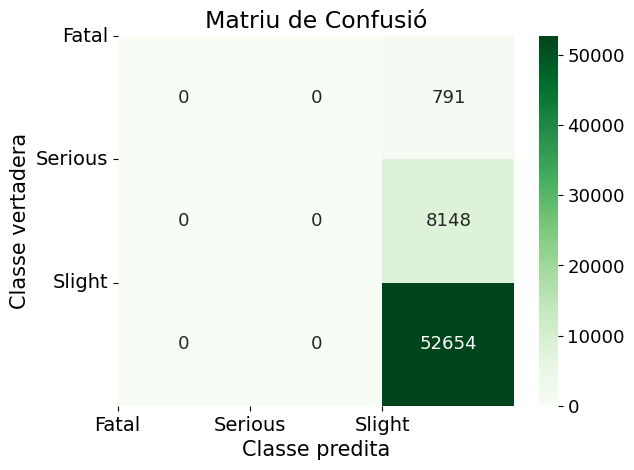

In [7]:
warnings.filterwarnings("ignore")

start_time = time.time()

X = dades_desequilibrades.drop('Accident_Severity', axis=1)
y = dades_desequilibrades['Accident_Severity']

escalar = StandardScaler()
X_escalat = pd.DataFrame(escalar.fit_transform(X))

noms_classes = ["Fatal", "Serious", "Slight"] # 0, 1, 2

model_reglog = LogisticRegression(
    multi_class = 'multinomial',
    solver = 'lbfgs',
    max_iter = 2000
)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)

accuracy_reglog_0 =[]
precisio_reglog_0_3, precisio_reglog_0 = [], []
f1_reglog_0_3, f1_reglog_0 = [], []
sensibilitat_reglog_0_3, sensibilitat_reglog_0 = [], []
balanced_accuracy_reglog_0 = []
mc_reglog_0 = []
especificitat_reglog_0_3, especificitat_reglog_0 = [], []
mae_reglog_0 = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X_escalat.iloc[train_index], X_escalat.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    model_reglog.fit(X_train, y_train)
    y_pred_reglog = model_reglog.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_reglog)
    cm_df = pd.DataFrame(cm, index = noms_classes, columns = noms_classes)
   
    # Mètriques
    # Accuracy, Precisió, F1 Score, Sensibilitat
    accuracy_reglog_0.append(accuracy_score(y_test, y_pred_reglog))
    precisio_reglog_0_3.append(precision_score(y_test, y_pred_reglog, average=None))
    precisio_reglog_0.append(precision_score(y_test, y_pred_reglog, average = 'weighted'))
    f1_reglog_0_3.append(f1_score(y_test, y_pred_reglog, average = None))
    f1_reglog_0.append(f1_score(y_test, y_pred_reglog, average = 'weighted'))
    sensibilitat_reglog_0_3.append(recall_score(y_test, y_pred_reglog, average = None))
    sensibilitat_ponderada = recall_score(y_test, y_pred_reglog, average = 'weighted')
    sensibilitat_reglog_0.append(sensibilitat_ponderada)
    mc_reglog_0.append(cm)
   
    # Especificitat
    x = np.diag(cm)

    for i in noms_classes:
        index = noms_classes.index(i)
        TN = cm_df.drop(i, axis = 0).drop(i, axis = 1).values.sum()
        FP = cm_df[i].sum() - cm_df.loc[i, i]
        especificitat = TN / (TN + FP) if (TN + FP) > 0 else 0
        especificitat_reglog_0_3.append(especificitat)
       
    especificitat_ponderada = (especificitat_reglog_0_3[0]*x[0] + especificitat_reglog_0_3[1]*x[1] +
                        especificitat_reglog_0_3[2]*x[2]) / sum(x)
   
    especificitat_reglog_0.append(especificitat_ponderada)
   
    # Balanced Accuracy
    ba = (sensibilitat_ponderada + especificitat_ponderada) / 2
    balanced_accuracy_reglog_0.append(ba)
   
    # MAE
    pesos = np.array([
    [0, 1, 2],
    [1, 0, 1],
    [2, 1, 0]
    ])

    n = np.sum(cm)
    mae = np.sum(cm * pesos) / n
    mae_reglog_0.append(mae)
   
end_time = time.time()
total_time_reglog_0 = round(end_time - start_time,2)
   
# Matriu de confusió
matriu_conf_reglog_0 = np.round(np.mean(mc_reglog_0, axis = 0))
matriu_conf_reglog_0_df = pd.DataFrame(matriu_conf_reglog_0, index=["Fatal", "Serious", "Slight"],
                                   columns=["Fatal", "Serious", "Slight"])
matriu_conf_reglog_0_df = np.round(matriu_conf_reglog_0_df)
plt.rcParams.update({'font.size': 13})
np.set_printoptions(formatter={'float': '{:.0f}'.format})

sns.heatmap(matriu_conf_reglog_0_df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Classe predita', fontsize = 15)
plt.ylabel('Classe vertadera', fontsize = 15)
plt.xticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.yticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.title('Matriu de Confusió', fontsize = 17)
plt.show()     

In [8]:
# COMPROBACIÓ - ELIMINAR
np.set_printoptions(precision=3)
print(especificitat_reglog_0_3)
print(especificitat_reglog_0)
print(mae_reglog_0)
print(f1_reglog_0_3)
print(precisio_reglog_0_3)
print(balanced_accuracy_reglog_0)
print(sensibilitat_reglog_0)
print(f1_reglog_0)
print(accuracy_reglog_0)

[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.15794002565226567, 0.15797249687464485, 0.15797249687464485, 0.15797249687464485, 0.1579263540719574]
[array([0.   , 0.   , 0.922]), array([0.   , 0.   , 0.922]), array([0.   , 0.   , 0.922]), array([0.   , 0.   , 0.922]), array([0.   , 0.   , 0.922])]
[array([0.   , 0.   , 0.855]), array([0.   , 0.   , 0.855]), array([0.   , 0.   , 0.855]), array([0.   , 0.   , 0.855]), array([0.   , 0.   , 0.855])]
[0.42744305359375256, 0.4274349357881577, 0.4274349357881577, 0.4274349357881577, 0.4274499935056501]
[0.8548861071875051, 0.8548698715763154, 0.8548698715763154, 0.8548698715763154, 0.8548999870113002]
[0.7880055313696184, 0.7879824978857968, 0.7879824978857968, 0.7879824978857968, 0.7880252228256324]
[0.8548861071875051, 0.8548698715763154, 0.8548698715763154, 0.8548698715763154, 0.8548999870113002]


**Amb tècnica SMOTE**

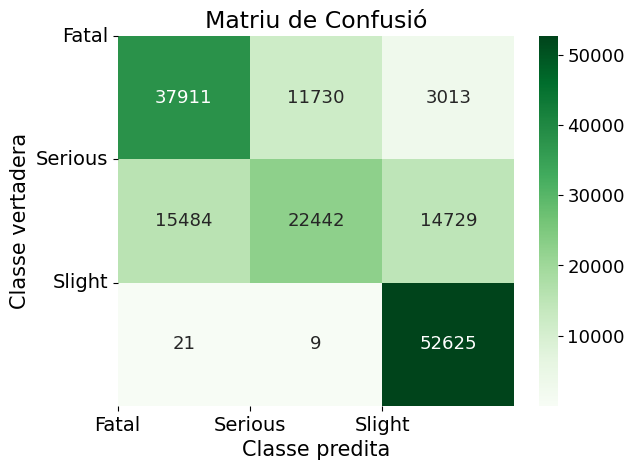

In [9]:
start_time = time.time()

X = dades_equilibrades.drop('Accident_Severity', axis=1)
y = dades_equilibrades['Accident_Severity']

escalar = StandardScaler()
X_escalat = pd.DataFrame(escalar.fit_transform(X))

noms_classes = ["Fatal", "Serious", "Slight"] # 0, 1, 2

model_reglog = LogisticRegression(
    multi_class = 'multinomial',
    solver = 'lbfgs',
    max_iter = 2000
)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)

accuracy_reglog =[]
precisio_reglog_3, precisio_reglog = [], []
f1_reglog_3, f1_reglog = [], []
sensibilitat_reglog_3, sensibilitat_reglog = [], []
balanced_accuracy_reglog = []
mc_reglog = []
especificitat_reglog_3, especificitat_reglog = [], []
mae_reglog = []


for train_index, test_index in cv.split(X, y):
    X_train, X_test = X_escalat.iloc[train_index], X_escalat.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    model_reglog.fit(X_train, y_train)
    y_pred_reglog = model_reglog.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_reglog)
    cm_df = pd.DataFrame(cm, index = noms_classes, columns = noms_classes)
   
    # Mètriques
    # Accuracy, Precisió, F1 Score, Sensibilitat
    accuracy_reglog.append(accuracy_score(y_test, y_pred_reglog))
    precisio_reglog_3.append(precision_score(y_test, y_pred_reglog, average=None))
    precisio_reglog.append(precision_score(y_test, y_pred_reglog, average = 'weighted'))
    f1_reglog_3.append(f1_score(y_test, y_pred_reglog, average = None))
    f1_reglog.append(f1_score(y_test, y_pred_reglog, average = 'weighted'))
    sensibilitat_reglog_3.append(recall_score(y_test, y_pred_reglog, average = None))
    sensibilitat_ponderada = recall_score(y_test, y_pred_reglog, average = 'weighted')
    sensibilitat_reglog.append(sensibilitat_ponderada)
    mc_reglog.append(cm)
   
    # Especificitat
    x = np.diag(cm)

    for i in noms_classes:
        index = noms_classes.index(i)
        TN = cm_df.drop(i, axis = 0).drop(i, axis = 1).values.sum()
        FP = cm_df[i].sum() - cm_df.loc[i, i]
        especificitat = TN / (TN + FP) if (TN + FP) > 0 else 0
        especificitat_reglog_3.append(especificitat)
       
    especificitat_ponderada = (especificitat_reglog_3[0]*x[0] + especificitat_reglog_3[1]*x[1] +
                        especificitat_reglog_3[2]*x[2]) / sum(x)
   
    especificitat_reglog.append(especificitat_ponderada)
   
    # Balanced Accuracy
    ba = (sensibilitat_ponderada + especificitat_ponderada) / 2
    balanced_accuracy_reglog.append(ba)
   
    # MAE
    pesos = np.array([
    [0, 1, 2],
    [1, 0, 1],
    [2, 1, 0]
    ])

    n = np.sum(cm)
    mae = np.sum(cm * pesos) / n
    mae_reglog.append(mae)
    
end_time = time.time()
total_time_reglog = round(end_time - start_time,2)
   
# Matriu de confusió
matriu_conf_reglog = np.round(np.mean(mc_reglog, axis = 0))
matriu_conf_reglog_df = pd.DataFrame(matriu_conf_reglog, index=["Fatal", "Serious", "Slight"],
                                   columns=["Fatal", "Serious", "Slight"])
matriu_conf_reglog_df = np.round(matriu_conf_reglog_df)
plt.rcParams.update({'font.size': 13})
np.set_printoptions(formatter={'float': '{:.0f}'.format})

sns.heatmap(matriu_conf_reglog_df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Classe predita', fontsize = 15)
plt.ylabel('Classe vertadera', fontsize = 15)
plt.xticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.yticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.title('Matriu de Confusió', fontsize = 17)
plt.show()

In [10]:
# COMPROBACIÓ - ELIMINAR
np.set_printoptions(precision=4)
print(especificitat_reglog_3)
print(especificitat_reglog)
print(mae_reglog)
print(f1_reglog_3)
print(precisio_reglog_3)
print(balanced_accuracy_reglog)
print(sensibilitat_reglog)
print(f1_reglog)
print(accuracy_reglog)

[0.8539441073412529, 0.8879108148401371, 0.8312600892602792, 0.8525767028459106, 0.8883180764994113, 0.8315243711363701, 0.8520734220247083, 0.8890313268571537, 0.8321210164469935, 0.853070487802562, 0.8897435166984778, 0.8315702510730428, 0.8521954647320241, 0.8876164430390565, 0.8311730241479836]
[0.8501381565210276, 0.8501358646035232, 0.8501014578998057, 0.8501435258656154, 0.8501062662221353]
[0.3034172343065509, 0.3046029766464299, 0.30327355140127754, 0.303032988737869, 0.30559688028209137]
[array([0.7157, 0.5171, 0.8553]), array([0.7139, 0.5173, 0.8555]), array([0.7158, 0.5158, 0.856 ]), array([0.7163, 0.5185, 0.8557]), array([0.7125, 0.5157, 0.8553])]
[array([0.7114, 0.6557, 0.7475]), array([0.7091, 0.6565, 0.7478]), array([0.7094, 0.6568, 0.7485]), array([0.7107, 0.6595, 0.748 ]), array([0.7081, 0.6543, 0.7475])]
[0.7827739983688929, 0.7825408848286192, 0.7827927318239936, 0.7831999321876332, 0.7820481256093108]
[0.7154098402167582, 0.7149459050537151, 0.7154840057481815, 0.7

#### RANDOM FOREST

Random forest es un algoritme basat en arbres de decisió que construeix múltiples arbres utilitzant subconjunts aleatoris de característiques. A diferència dels models lineals (com regressió lineal o SVM lineal), els arbres de decisió a Random Forest no es veuen afectats per l'escala absoluta de les característiques. Els arbres de decisió divideixen les característiques en llindars específics durant l'entrenament, i aquestes divisions es fan de manera relativa en comptes d'absoluta.

- **Simplicidad y Eficiencia:** No escalar los datos simplifica el proceso de preprocesamiento y entrenamiento del modelo. No es necesario aplicar transformaciones adicionales a las características antes de alimentar el modelo.

- **Menor Sensibilidad a Outliers:** Random Forest es menos sensible a valores atípicos (outliers) en los datos en comparación con algunos algoritmos sensibles a la escala, como la regresión lineal.

- **Mayor Interpretabilidad:** Las características conservan su interpretación original sin necesidad de ajustar sus escalas, lo que facilita la comprensión y la interpretación de los resultados del modelo.

In [ ]:
# Busquem els millors paràmetres per realitzar un Random Forest
X = dades_equilibrades.drop('Accident_Severity', axis=1) 
y = dades_equilibrades['Accident_Severity'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

param_grid = {
    'max_depth': [None, 3 ,5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'bootstrap': [True, False],
    'criterion': ["gini", "entropy", "log_loss"]
}

rf = RandomForestClassifier(random_state = 123)

search = HalvingGridSearchCV(rf, param_grid, cv = 5, factor = 2,  n_jobs = -1)

search.fit(X_train, y_train)


print(search.best_params_)
print(np.mean(search.best_score_))
#{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

**Sense tècnica Smote**

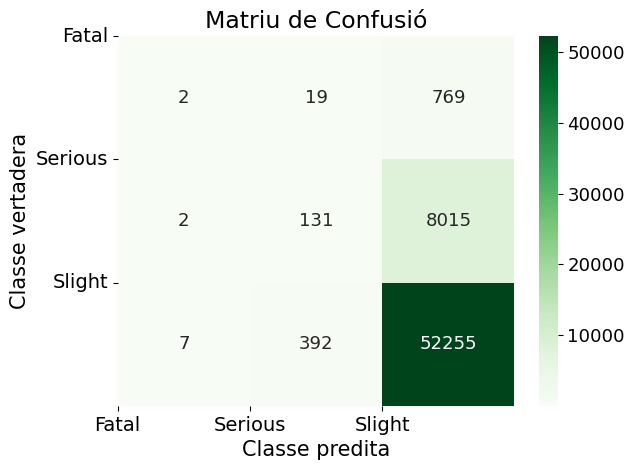

In [11]:
start_time = time.time()

X = dades_desequilibrades.drop('Accident_Severity', axis=1)
y = dades_desequilibrades['Accident_Severity']

noms_classes = ["Fatal", "Serious", "Slight"]

start_time = time.time()

model_rf = RandomForestClassifier(
    n_estimators=300,        
    max_depth=None,          
    min_samples_leaf=1,      
    min_samples_split=5,
    bootstrap=False,
    criterion='gini',
    random_state=123          
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

accuracy_rf_0 = []
precisio_rf_0_3 = []
precisio_rf_0 = []
f1_rf_0_3 = []
f1_rf_0 = []
sensibilitat_rf_0_3 = []
sensibilitat_rf_0 = []
balanced_accuracy_rf_0 = []
mc_rf_0 = []
especificitat_rf_0_3 = []
especificitat_rf_0 = []
mae_rf_0 = []


for train_index, test_index in cv.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_rf)
    cm_df = pd.DataFrame(cm, index = noms_classes, columns = noms_classes)

    # Mètriques
    # Accuracy, Precisió, F1 Score, Sensibilitat
    accuracy_rf_0.append(accuracy_score(y_test, y_pred_rf))
    precisio_rf_0_3.append(precision_score(y_test, y_pred_rf, average=None))
    precisio_rf_0.append(precision_score(y_test, y_pred_rf, average = 'weighted'))
    f1_rf_0_3.append(f1_score(y_test, y_pred_rf, average = None))
    f1_rf_0.append(f1_score(y_test, y_pred_rf, average = 'weighted'))
    sensibilitat_rf_0_3.append(recall_score(y_test, y_pred_rf, average = None))
    sensibilitat_ponderada = recall_score(y_test, y_pred_rf, average = 'weighted')
    sensibilitat_rf_0.append(sensibilitat_ponderada)
    mc_rf_0.append(cm)
   
    # Especificitat
    x = np.diag(cm)

    for i in noms_classes:
        index = noms_classes.index(i)
        TN = cm_df.drop(i, axis = 0).drop(i, axis = 1).values.sum()
        FP = cm_df[i].sum() - cm_df.loc[i, i]
        especificitat = TN / (TN + FP) if (TN + FP) > 0 else 0
        especificitat_rf_0_3.append(especificitat)
       
    especificitat_ponderada = (especificitat_rf_0_3[0]*x[0] + especificitat_rf_0_3[1]*x[1] +
                        especificitat_rf_0_3[2]*x[2]) / sum(x)
   
    especificitat_rf_0.append(especificitat_ponderada)


    # Balanced Accuracy
    ba = (sensibilitat_ponderada + especificitat_ponderada) / 2
    balanced_accuracy_rf_0.append(ba)
   
    # MAE
    pesos = np.array([
    [0, 1, 2],
    [1, 0, 1],
    [2, 1, 0]
    ])

    n = np.sum(cm)
    mae = np.sum(cm * pesos) / n
    mae_rf_0.append(mae)
    
end_time = time.time()
total_time_rf_0 = round(end_time - start_time,2)

# Matriu de confusió
matriu_conf_rf_0 = np.round(np.mean(mc_rf_0, axis = 0))
matriu_conf_rf_0_df = pd.DataFrame(matriu_conf_rf_0, index=["Fatal", "Serious", "Slight"],
                                   columns=["Fatal", "Serious", "Slight"])
matriu_conf_rf_0_df = np.round(matriu_conf_rf_0_df)
plt.rcParams.update({'font.size': 13})
np.set_printoptions(formatter={'float': '{:.0f}'.format})

sns.heatmap(matriu_conf_rf_0_df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Classe predita', fontsize = 15)
plt.ylabel('Classe vertadera', fontsize = 15)
plt.xticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.yticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.title('Matriu de Confusió', fontsize = 17)
plt.show()

In [12]:
# COMPROBACIÓ - ELIMINAR
np.set_printoptions(precision=2)
print(especificitat_rf_0_3)
print(especificitat_rf_0)
print(mae_rf_0)
print(f1_rf_0_3)
print(precisio_rf_0_3)
print(balanced_accuracy_rf_0)
print(sensibilitat_rf_0)
print(accuracy_rf_0)

[0.999736855089387, 0.9929647300963608, 0.01633475050346834, 0.9999342126903721, 0.992160164655253, 0.017451616511914084, 0.999901319035558, 0.9915988399288989, 0.019465264570981095, 0.999868425380744, 0.9916736832257461, 0.01823470186821792, 0.999868425380744, 0.9930957058658434, 0.014993845809555779]
[0.01868273228958722, 0.018796220294279548, 0.019094981029783943, 0.01892759832904299, 0.01862669676558247]
[0.1618690435601448, 0.161901514782524, 0.16216128456155732, 0.1623723475070219, 0.16182296402130147]
[array([0.  , 0.03, 0.92]), array([0.01, 0.03, 0.92]), array([0.01, 0.03, 0.92]), array([0.01, 0.03, 0.92]), array([0.  , 0.03, 0.92])]
[array([0.  , 0.25, 0.86]), array([0.56, 0.23, 0.86]), array([0.33, 0.24, 0.86]), array([0.27, 0.23, 0.86]), array([0.  , 0.25, 0.86])]
[0.4347874395622274, 0.4346655918414881, 0.43470132293091324, 0.4345445713301897, 0.4347906831015859]
[0.8508921468348676, 0.8505349633886967, 0.8503076648320426, 0.8501615443313364, 0.8509546694375894]
[0.85089214

**Amb tècnica Smote**

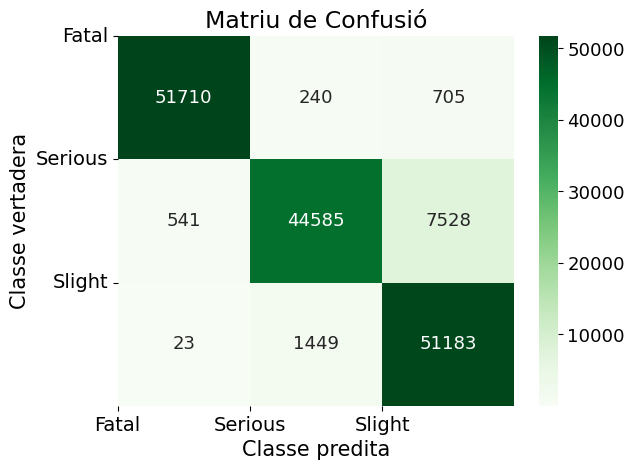

In [13]:
start_time = time.time()

X = dades_equilibrades.drop('Accident_Severity', axis=1)
y = dades_equilibrades['Accident_Severity']

noms_classes = ["Fatal", "Serious", "Slight"] # 0, 1, 2

model_rf = RandomForestClassifier(
    n_estimators=300,        
    max_depth=None,          
    min_samples_leaf=1,      
    min_samples_split=5,
    bootstrap=False,
    criterion='gini',
    random_state=123            
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

accuracy_rf = []
precisio_rf_3 = []
precisio_rf = []
f1_rf_3 = []
f1_rf = []
sensibilitat_rf_3 = []
sensibilitat_rf = []
balanced_accuracy_rf = []
mc_rf = []
especificitat_rf_3 = []
especificitat_rf = []
mae_rf = []

for train_index, test_index in cv.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_rf)
    cm_df = pd.DataFrame(cm, index = noms_classes, columns = noms_classes) # diferent cada vegada

    # Mètriques
    # Accuracy, Precisió, F1 Score, Sensibilitat
    accuracy_rf.append(accuracy_score(y_test, y_pred_rf))
    precisio_rf_3.append(precision_score(y_test, y_pred_rf, average=None))
    precisio_rf.append(precision_score(y_test, y_pred_rf, average = 'weighted'))
    f1_rf_3.append(f1_score(y_test, y_pred_rf, average = None))
    f1_rf.append(f1_score(y_test, y_pred_rf, average = 'weighted'))
    sensibilitat_rf_3.append(recall_score(y_test, y_pred_rf, average = None))
    sensibilitat_ponderada = recall_score(y_test, y_pred_rf, average = 'weighted')
    sensibilitat_rf.append(sensibilitat_ponderada)
    mc_rf.append(cm) # anem guardant totes les matrius de confusió
   
    # Especificitat
    x = np.diag(cm)

    for i in noms_classes:
        index = noms_classes.index(i)
        TN = cm_df.drop(i, axis = 0).drop(i, axis = 1).values.sum()
        FP = cm_df[i].sum() - cm_df.loc[i, i]
        especificitat = TN / (TN + FP) if (TN + FP) > 0 else 0
        especificitat_rf_3.append(especificitat)
       
    especificitat_ponderada = (especificitat_rf_3[0]*x[0] + especificitat_rf_3[1]*x[1] +
                        especificitat_rf_3[2]*x[2]) / sum(x)
   
    especificitat_rf.append(especificitat_ponderada)


    # Balanced Accuracy
    ba = (sensibilitat_ponderada + especificitat_ponderada) / 2
    balanced_accuracy_rf.append(ba)
   
    # MAE
    pesos = np.array([
    [0, 1, 2],
    [1, 0, 1],
    [2, 1, 0]
    ])

    n = np.sum(cm)
    mae = np.sum(cm * pesos) / n
    mae_rf.append(mae)
    
end_time = time.time()
total_time_rf = round(end_time - start_time,2)

# Matriu de confusió
matriu_conf_rf = np.round(np.mean(mc_rf, axis = 0))
matriu_conf_rf_df = pd.DataFrame(matriu_conf_rf, index=["Fatal", "Serious", "Slight"],
                                   columns=["Fatal", "Serious", "Slight"])
matriu_conf_rf_df = np.round(matriu_conf_rf_df)
plt.rcParams.update({'font.size': 13})
np.set_printoptions(formatter={'float': '{:.0f}'.format})

sns.heatmap(matriu_conf_rf_df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Classe predita', fontsize = 15)
plt.ylabel('Classe vertadera', fontsize = 15)
plt.xticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.yticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.title('Matriu de Confusió', fontsize = 17)
plt.show()

In [14]:
np.set_printoptions(precision=2)
print(especificitat_rf_3)
print(especificitat_rf)
print(mae_rf)
print(f1_rf_3)
print(precisio_rf_3)
print(balanced_accuracy_rf)
print(sensibilitat_rf)
print(accuracy_rf)

[0.994454415102223, 0.983353749442118, 0.9217453233311177, 0.994511390289529, 0.9850818551297147, 0.9222953403792649, 0.9946253406641408, 0.9833442535775669, 0.9223135944087819, 0.9948437455488135, 0.9839329971797283, 0.9211455919778174, 0.9948152087210849, 0.984094426877095, 0.9216116381315936]
[0.9658848905010445, 0.9658376853638001, 0.9658849017843866, 0.9658581787855628, 0.9658574106236955]
[0.07142766706338154, 0.07009236340155606, 0.07090267974145845, 0.07166235131011693, 0.0708203819881871]
[array([0.99, 0.9 , 0.91]), array([0.99, 0.9 , 0.91]), array([0.99, 0.9 , 0.91]), array([0.99, 0.9 , 0.91]), array([0.99, 0.9 , 0.91])]
[array([0.99, 0.96, 0.86]), array([0.99, 0.97, 0.86]), array([0.99, 0.96, 0.86]), array([0.99, 0.96, 0.86]), array([0.99, 0.96, 0.86])]
[0.9494601328249064, 0.9502149816511524, 0.9497036544651819, 0.9495700116340657, 0.9497690413399049]
[0.9330353751487681, 0.9345922779385046, 0.9335224071459772, 0.9332818444825687, 0.9336806720561144]
[0.9330353751487681, 0.

#### GRADIENT BOOSTING (XGBoost)

No cal escalar les dades en algoritmes basats en arbres de decisió com el Random forest i el XGBoost. Aquests models son intrinsicament robusts a l'escala de les característiques.

**Sense tècnica SMOTE**

In [ ]:
# Busquem els millors paràmetres per realitzar un XGBoost
X = dades_equilibrades.drop('Accident_Severity', axis=1) 
y = dades_equilibrades['Accident_Severity'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

param_grid = {
    'max_depth': [None, 3 ,5, 7, 10, 15],
    'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    'subsample': [0.25, 0.5, 1],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.3, 0.6, 1]
    
}

xgb = XGBClassifier(random_state = 123, objective = 'multi:softmax', n_estimators = 300)

search = HalvingGridSearchCV(xgb, param_grid, cv = 5, factor = 2,  n_jobs = -1)

search.fit(X_train, y_train)


print(search.best_params_)
print(np.mean(search.best_score_))
#{'colsample_bytree': 0.8, 'gamma': 0.6, 'learning_rate': 0.05, 'max_depth': 15, 'subsample': 0.5}

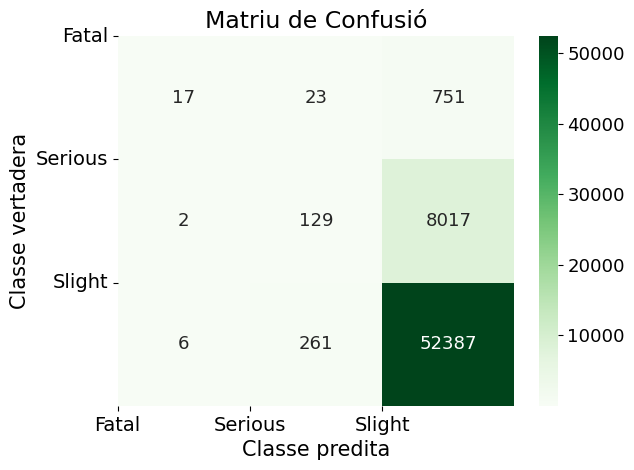

In [15]:
start_time = time.time()

X = dades_desequilibrades.drop('Accident_Severity', axis=1)
y = dades_desequilibrades['Accident_Severity']

noms_classes = ["Fatal", "Serious", "Slight"]

start_time = time.time()

model_xgb = XGBClassifier(
    objective = 'multi:softmax',
    n_estimators = 300,
    max_depth = 15,
    learning_rate = 0.05,
    subsample = 0.5,
    colsample_bytree = 0.8,
    random_state = 123)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

accuracy_xgb_0 = []
precisio_xgb_0_3 = []
precisio_xgb_0 = []
f1_xgb_0_3 = []
f1_xgb_0 = []
sensibilitat_xgb_0_3 = []
sensibilitat_xgb_0 = []
balanced_accuracy_xgb_0 = []
mc_xgb_0 = []
especificitat_xgb_0_3 = []
especificitat_xgb_0 = []
mae_xgb_0 = []


for train_index, test_index in cv.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_xgb)
    cm_df = pd.DataFrame(cm, index = noms_classes, columns = noms_classes)

    # Mètriques
    # Accuracy, Precisió, F1 Score, Sensibilitat
    accuracy_xgb_0.append(accuracy_score(y_test, y_pred_xgb))
    precisio_xgb_0_3.append(precision_score(y_test, y_pred_xgb, average=None))
    precisio_xgb_0.append(precision_score(y_test, y_pred_xgb, average = 'weighted'))
    f1_xgb_0_3.append(f1_score(y_test, y_pred_xgb, average = None))
    f1_xgb_0.append(f1_score(y_test, y_pred_xgb, average = 'weighted'))
    sensibilitat_xgb_0_3.append(recall_score(y_test, y_pred_xgb, average = None))
    sensibilitat_ponderada = recall_score(y_test, y_pred_xgb, average = 'weighted')
    sensibilitat_xgb_0.append(sensibilitat_ponderada)
    mc_xgb_0.append(cm)
   
    # Especificitat
    x = np.diag(cm)

    for i in noms_classes:
        index = noms_classes.index(i)
        TN = cm_df.drop(i, axis = 0).drop(i, axis = 1).values.sum()
        FP = cm_df[i].sum() - cm_df.loc[i, i]
        especificitat = TN / (TN + FP) if (TN + FP) > 0 else 0
        especificitat_xgb_0_3.append(especificitat)
       
    especificitat_ponderada = (especificitat_xgb_0_3[0]*x[0] + especificitat_xgb_0_3[1]*x[1] +
                        especificitat_xgb_0_3[2]*x[2]) / sum(x)
   
    especificitat_xgb_0.append(especificitat_ponderada)


    # Balanced Accuracy
    ba = (sensibilitat_ponderada + especificitat_ponderada) / 2
    balanced_accuracy_xgb_0.append(ba)
   
    # MAE
    pesos = np.array([
    [0, 1, 2],
    [1, 0, 1],
    [2, 1, 0]
    ])

    n = np.sum(cm)
    mae = np.sum(cm * pesos) / n
    mae_xgb_0.append(mae)
    
end_time = time.time()
total_time_xgb_0 = round(end_time - start_time,2)

# Matriu de confusió
matriu_conf_xgb_0 = np.round(np.mean(mc_xgb_0, axis = 0))
matriu_conf_xgb_0_df = pd.DataFrame(matriu_conf_xgb_0, index=["Fatal", "Serious", "Slight"],
                                   columns=["Fatal", "Serious", "Slight"])
matriu_conf_xgb_0_df = np.round(matriu_conf_xgb_0_df)
plt.rcParams.update({'font.size': 13})
np.set_printoptions(formatter={'float': '{:.0f}'.format})

sns.heatmap(matriu_conf_xgb_0_df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Classe predita', fontsize = 15)
plt.ylabel('Classe vertadera', fontsize = 15)
plt.xticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.yticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.title('Matriu de Confusió', fontsize = 17)
plt.show()

In [16]:
np.set_printoptions(precision=2)
print(especificitat_xgb_0_3)
print(especificitat_xgb_0)
print(mae_xgb_0)
print(f1_xgb_0_3)
print(precisio_xgb_0_3)
print(balanced_accuracy_xgb_0)
print(accuracy_xgb_0)

[0.9998848741016069, 0.994966788287024, 0.018124860147684045, 0.9998519785533371, 0.994779680044906, 0.020360219263899765, 0.9998519785533371, 0.9946112826269997, 0.01857030987806242, 0.999868425380744, 0.9944428852090934, 0.020360219263899765, 0.999868425380744, 0.9946299934512115, 0.018014993845809554]
[0.020803417671398268, 0.020989423985773706, 0.02086059891102506, 0.020971661856198663, 0.020581436067552784]
[0.15938499504813858, 0.1590765184355365, 0.15962852921598233, 0.15933628821456983, 0.15950123392648397]
[array([0.03, 0.03, 0.92]), array([0.05, 0.03, 0.92]), array([0.05, 0.03, 0.92]), array([0.04, 0.03, 0.92]), array([0.04, 0.03, 0.92])]
[array([0.67, 0.33, 0.86]), array([0.68, 0.33, 0.86]), array([0.68, 0.31, 0.86]), array([0.69, 0.31, 0.86]), array([0.67, 0.29, 0.86])]
[0.43691933259164545, 0.4370691603879967, 0.4368018027107526, 0.43692227662809774, 0.4366529079285679]
[0.8530352475118926, 0.8531488967902197, 0.8527430065104801, 0.8528728913999968, 0.852724379789583]


**Amb tècnica SMOTE**

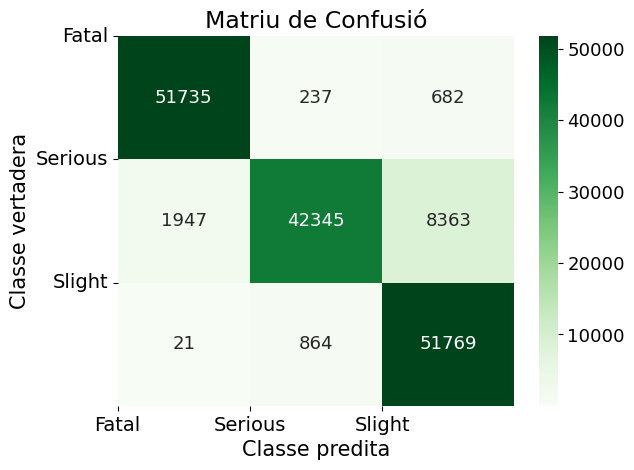

In [17]:
# Amb Cross Validation + parametres

start_time = time.time()

X = dades_equilibrades.drop('Accident_Severity', axis=1)
y = dades_equilibrades['Accident_Severity']

noms_classes = ["Fatal", "Serious", "Slight"] # 0, 1, 2

model_xgb = XGBClassifier(
    objective = 'multi:softmax',
    n_estimators = 300,
    max_depth = 15,
    learning_rate = 0.05,
    subsample = 0.5,
    colsample_bytree = 0.8,
    random_state = 123)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

accuracy_xgb = []
precisio_xgb_3 = []
precisio_xgb = []
f1_xgb_3 = []
f1_xgb = []
sensibilitat_xgb_3 = []
sensibilitat_xgb = []
balanced_accuracy_xgb = []
mc_xgb = []
especificitat_xgb_3 = []
especificitat_xgb = []
mae_xgb = []

for train_index, test_index in cv.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_xgb)
    cm_df = pd.DataFrame(cm, index = noms_classes, columns = noms_classes) # diferent cada vegada

    # Mètriques
    # Accuracy, Precisió, F1 Score, Sensibilitat
    accuracy_xgb.append(accuracy_score(y_test, y_pred_xgb))
    precisio_xgb_3.append(precision_score(y_test, y_pred_xgb, average=None))
    precisio_xgb.append(precision_score(y_test, y_pred_xgb, average = 'weighted'))
    f1_xgb_3.append(f1_score(y_test, y_pred_xgb, average = None))
    f1_xgb.append(f1_score(y_test, y_pred_xgb, average = 'weighted'))
    sensibilitat_xgb_3.append(recall_score(y_test, y_pred_xgb, average = None))
    sensibilitat_ponderada = recall_score(y_test, y_pred_xgb, average = 'weighted')
    sensibilitat_xgb.append(sensibilitat_ponderada)
    mc_xgb.append(cm) # anem guardant totes les matrius de confusió
   
    # Especificitat
    x = np.diag(cm)

    for i in noms_classes:
        index = noms_classes.index(i)
        TN = cm_df.drop(i, axis = 0).drop(i, axis = 1).values.sum()
        FP = cm_df[i].sum() - cm_df.loc[i, i]
        especificitat = TN / (TN + FP) if (TN + FP) > 0 else 0
        especificitat_xgb_3.append(especificitat)
       
    especificitat_ponderada = (especificitat_xgb_3[0]*x[0] + especificitat_xgb_3[1]*x[1] +
                        especificitat_xgb_3[2]*x[2]) / sum(x)
   
    especificitat_xgb.append(especificitat_ponderada)


    # Balanced Accuracy
    ba = (sensibilitat_ponderada + especificitat_ponderada) / 2
    balanced_accuracy_xgb.append(ba)
   
    # MAE
    pesos = np.array([
    [0, 1, 2],
    [1, 0, 1],
    [2, 1, 0]
    ])

    n = np.sum(cm)
    mae = np.sum(cm * pesos) / n
    mae_xgb.append(mae)
    
end_time = time.time()
total_time_xgb = round(end_time - start_time,2)

# Matriu de confusió
matriu_conf_xgb = np.round(np.mean(mc_xgb, axis = 0))
matriu_conf_xgb_df = pd.DataFrame(matriu_conf_xgb, index=["Fatal", "Serious", "Slight"],
                                   columns=["Fatal", "Serious", "Slight"])
matriu_conf_xgb_df = np.round(matriu_conf_xgb_df)
plt.rcParams.update({'font.size': 13})
np.set_printoptions(formatter={'float': '{:.0f}'.format})

sns.heatmap(matriu_conf_xgb_df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Classe predita', fontsize = 15)
plt.ylabel('Classe vertadera', fontsize = 15)
plt.xticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.yticks(ticks = np.arange(len(noms_classes)), labels = noms_classes, rotation = 0, fontsize = 14)
plt.title('Matriu de Confusió', fontsize = 17)
plt.show()

In [18]:
np.set_printoptions(precision=2)
print(especificitat_xgb_3)
print(especificitat_xgb)
print(mae_xgb)
print(f1_xgb_3)
print(precisio_xgb_3)
print(balanced_accuracy_xgb)
print(accuracy_xgb)
print(f1_xgb)

[0.9801821306820879, 0.9899628711696057, 0.9138258474978634, 0.9817964276557559, 0.9896873931705094, 0.9144992355829037, 0.9812836509700026, 0.9890322764436088, 0.9142515288487104, 0.9818344111139599, 0.9898774083886468, 0.9143180005317735, 0.9814544004254188, 0.9891557226827716, 0.9136541036378657]
[0.9594405568324412, 0.9594749433028715, 0.9594705476612042, 0.9594847883183295, 0.959471516116576]
[0.08165784609151452, 0.0805378474706102, 0.08117090711115894, 0.0807404265555858, 0.08162037945594855]
[array([0.97, 0.88, 0.91]), array([0.97, 0.88, 0.91]), array([0.97, 0.88, 0.91]), array([0.97, 0.88, 0.91]), array([0.97, 0.88, 0.91])]
[array([0.96, 0.98, 0.85]), array([0.96, 0.98, 0.85]), array([0.96, 0.97, 0.85]), array([0.96, 0.98, 0.85]), array([0.96, 0.97, 0.85])]
[0.941043744522422, 0.9417317361310924, 0.9412579088780499, 0.9417524851298351, 0.941157103563248]
[0.9226469322124028, 0.9239885289593133, 0.9230452700948957, 0.9240201819413407, 0.92284269100992]
[0.9214394709622198, 0.92

## EVALUACIÓ PER MÈTRIQUES

In [19]:
# només random forest 
np.set_printoptions(precision=2) # això em posa 2 decimals

metriques = pd.DataFrame({
    'Model': ['Random Forest (Smote)', 'Random Forest (No Smote)'],
    'Accuracy': [round(np.mean(accuracy_rf),3), round(np.mean(accuracy_rf_0),3)],
    'Balanced Accuracy': [round(np.mean(balanced_accuracy_rf),3), round(np.mean(balanced_accuracy_rf_0),3)],
    'Sensibilitat': [round(np.mean(sensibilitat_rf),3), round(np.mean(sensibilitat_rf_0),3)],
    'Especificitat': [round(np.mean(especificitat_rf),3), round(np.mean(especificitat_rf_0),3)],
    'Precisió': [round(np.mean(precisio_rf),3), round(np.mean(precisio_rf_0),3)],
    'F1 Score': [round(np.mean(f1_rf),3), round(np.mean(f1_rf_0),3)],
    'MAE': [round(np.mean(mae_rf),3), round(np.mean(mae_rf_0),3)],
    'Temps transcorregut': [round(total_time_rf/60,3), round(total_time_rf_0/60,3)]
})

metriques

,Model,Accuracy,Balanced Accuracy,Sensibilitat,Especificitat,Precisió,F1 Score,MAE,Temps transcorregut
0,Random Forest (Smote),0.934,0.950,0.934,0.966,0.938,0.933,0.071,62.196
1,Random Forest (No Smote),0.851,0.435,0.851,0.019,0.767,0.790,0.162,17.719


In [20]:
# només regressió logistica multinomial
np.set_printoptions(precision=2) # això em posa 2 decimals

metriques = pd.DataFrame({
    'Model': ['Regressió Logística Multinomial (Smote)', 'Regressió Logística Multinomial (No Smote)'],
    'Accuracy': [round(np.mean(accuracy_reglog),3), round(np.mean(accuracy_reglog_0),3)],
    'Balanced Accuracy': [round(np.mean(balanced_accuracy_reglog),3), round(np.mean(balanced_accuracy_reglog_0),3)],
    'Sensibilitat': [round(np.mean(sensibilitat_reglog),3), round(np.mean(sensibilitat_reglog_0),3)],
    'Especificitat': [round(np.mean(especificitat_reglog),3), round(np.mean(especificitat_reglog_0),3)],
    'Precisió': [round(np.mean(precisio_reglog),3), round(np.mean(precisio_reglog_0),3)],
    'F1 Score': [round(np.mean(f1_reglog),3), round(np.mean(f1_reglog_0),3)],
    'MAE': [round(np.mean(mae_reglog),3), round(np.mean(mae_reglog_0),3)],
    'Temps transcorregut': [round(total_time_reglog/60,3), round(total_time_reglog_0/60,3)]
})

metriques

,Model,Accuracy,Balanced Accuracy,Sensibilitat,Especificitat,Precisió,F1 Score,MAE,Temps transcorregut
0,Regressió Logística Multinomial (Smote),0.715,0.783,0.715,0.85,0.705,0.696,0.304,2.045
1,Regressió Logística Multinomial (No Smote),0.855,0.427,0.855,0.00,0.731,0.788,0.158,0.228


In [21]:
# només regressió XGB
np.set_printoptions(precision=2) # això em posa 2 decimals

metriques = pd.DataFrame({
    'Model': ['XGBoost (Smote)', 'XGBoost (No Smote)'],
    'Accuracy': [round(np.mean(accuracy_xgb),3), round(np.mean(accuracy_xgb_0),3)],
    'Balanced Accuracy': [round(np.mean(balanced_accuracy_xgb),3), round(np.mean(balanced_accuracy_xgb_0),3)],
    'Sensibilitat': [round(np.mean(sensibilitat_xgb),3), round(np.mean(sensibilitat_xgb_0),3)],
    'Especificitat': [round(np.mean(especificitat_xgb),3), round(np.mean(especificitat_xgb_0),3)],
    'Precisió': [round(np.mean(precisio_xgb),3), round(np.mean(precisio_xgb_0),3)],
    'F1 Score': [round(np.mean(f1_xgb),3), round(np.mean(f1_xgb_0),3)],
    'MAE': [round(np.mean(mae_xgb),3), round(np.mean(mae_xgb_0),3)],
    'Temps transcorregut': [round(total_time_xgb/60,3), round(total_time_xgb_0/60,3)]
})

metriques

,Model,Accuracy,Balanced Accuracy,Sensibilitat,Especificitat,Precisió,F1 Score,MAE,Temps transcorregut
0,XGBoost (Smote),0.923,0.941,0.923,0.959,0.930,0.922,0.081,9.943
1,XGBoost (No Smote),0.853,0.437,0.853,0.021,0.782,0.792,0.159,3.198


In [22]:
# junt

metriques_smote = pd.DataFrame({
    'Model': ['Regressió Logística Multinomial','Random Forest','XGBoost'],
    'Accuracy': [round(np.mean(accuracy_reglog),3), round(np.mean(accuracy_rf),3), round(np.mean(accuracy_xgb),3)],
    'Balanced Accuracy': [round(np.mean(balanced_accuracy_reglog),3), round(np.mean(balanced_accuracy_rf),3),
                          round(np.mean(balanced_accuracy_xgb),3)],
    'Sensibilitat': [round(np.mean(sensibilitat_reglog),3), round(np.mean(sensibilitat_rf),3),
                     round(np.mean(sensibilitat_xgb),3)],
    'Especificitat': [round(np.mean(especificitat_reglog),3), round(np.mean(especificitat_rf),3),
                      round(np.mean(especificitat_xgb),3)],
    'Precisió': [round(np.mean(precisio_reglog),3), round(np.mean(precisio_rf),3), round(np.mean(precisio_xgb),3)],
    'F1 Score': [round(np.mean(f1_reglog),3), round(np.mean(f1_rf),3), round(np.mean(f1_xgb),3)],
    'MAE': [round(np.mean(mae_reglog),3), round(np.mean(mae_rf),3), round(np.mean(mae_xgb),3)],
    'Temps transcorregut': [round(total_time_reglog/60,3), round(total_time_rf/60,3), round(total_time_xgb/60,3), ]
})


metriques_no_smote = pd.DataFrame({
    'Model': ['Regressió Logística Multinomial','Random Forest', 'XGBoost'],
    'Accuracy': [round(np.mean(accuracy_reglog_0),3), round(np.mean(accuracy_rf_0),3), round(np.mean(accuracy_xgb_0),3)],
    'Balanced Accuracy': [ round(np.mean(balanced_accuracy_reglog_0),3), round(np.mean(balanced_accuracy_rf_0),3),
                          round(np.mean(balanced_accuracy_xgb_0),3)],
    'Sensibilitat': [round(np.mean(sensibilitat_reglog_0),3), round(np.mean(sensibilitat_rf_0),3),
                     round(np.mean(sensibilitat_xgb_0),3)],
    'Especificitat': [round(np.mean(especificitat_reglog_0),3), round(np.mean(especificitat_rf_0),3),
                      round(np.mean(especificitat_xgb_0),3)],
    'Precisió': [round(np.mean(precisio_reglog_0),3), round(np.mean(precisio_rf_0),3), round(np.mean(precisio_xgb_0),3)],
    'F1 Score': [round(np.mean(f1_reglog_0),3), round(np.mean(f1_rf_0),3), round(np.mean(f1_xgb_0),3)],
    'MAE': [round(np.mean(mae_reglog_0),3), round(np.mean(mae_rf_0),3), round(np.mean(mae_xgb_0),3)],
    'Temps transcorregut': [round(total_time_reglog_0/60,3), round(total_time_rf_0/60,3), round(total_time_xgb_0/60,3)]
})

metriques_smote
#metriques_no_smote

,Model,Accuracy,Balanced Accuracy,Sensibilitat,Especificitat,Precisió,F1 Score,MAE,Temps transcorregut
0,Regressió Logística Multinomial,0.715,0.783,0.715,0.850,0.705,0.696,0.304,2.045
1,Random Forest,0.934,0.950,0.934,0.966,0.938,0.933,0.071,62.196
2,XGBoost,0.923,0.941,0.923,0.959,0.930,0.922,0.081,9.943


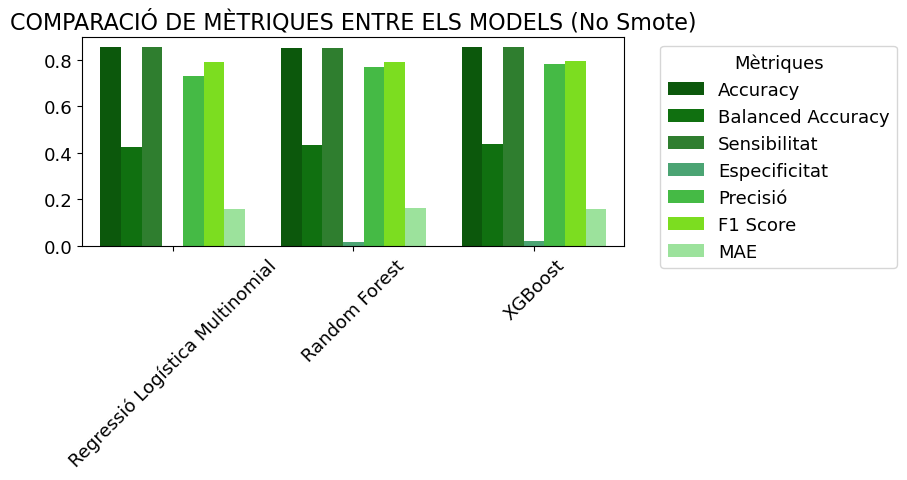

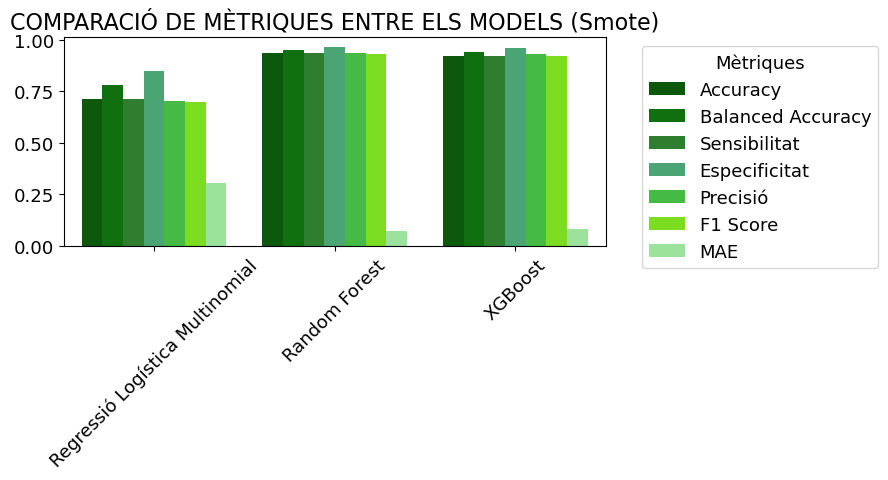

In [23]:
colors = {
    'Accuracy': '#006400',
    'Balanced Accuracy': '#008000',
    'Sensibilitat': '#228B22',
    'Especificitat': '#3CB371',
    'Precisió': '#32CD32',
    'F1 Score': '#7CFC00',
    'MAE': '#90EE90',
    'Temps transcorregut': '#90EE90'
}
metriques_1 = metriques_no_smote.iloc[:, :-1]
metriques_1 = metriques_1.melt(id_vars = 'Model', var_name = 'Mètrica', value_name = 'Valor')
plt.figure(figsize = (9, 5))
sns.barplot(data=metriques_1, x='Model', y='Valor', hue='Mètrica', palette=colors)

plt.xlabel("")
plt.ylabel("")
plt.title('COMPARACIÓ DE MÈTRIQUES ENTRE ELS MODELS (No Smote)', fontsize = 16)
plt.legend(title = 'Mètriques', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

metriques_2 = metriques_smote.iloc[:, :-1]
metriques_2 = metriques_2.melt(id_vars = 'Model', var_name = 'Mètrica', value_name = 'Valor')
plt.figure(figsize = (9, 5))
sns.barplot(data=metriques_2, x='Model', y='Valor', hue='Mètrica', palette=colors)

plt.xlabel("")
plt.ylabel("")
plt.title('COMPARACIÓ DE MÈTRIQUES ENTRE ELS MODELS (Smote)', fontsize = 16)
plt.legend(title = 'Mètriques', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

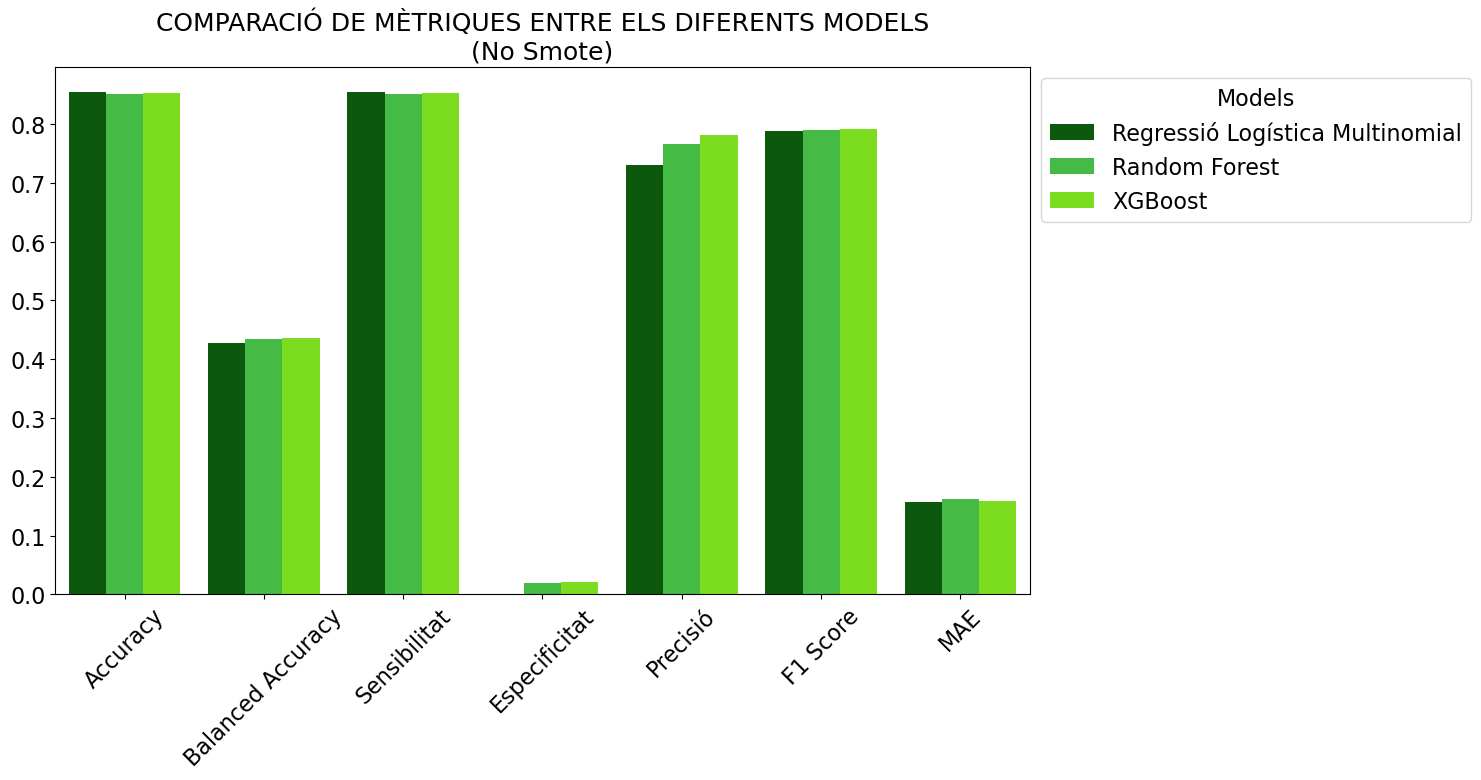

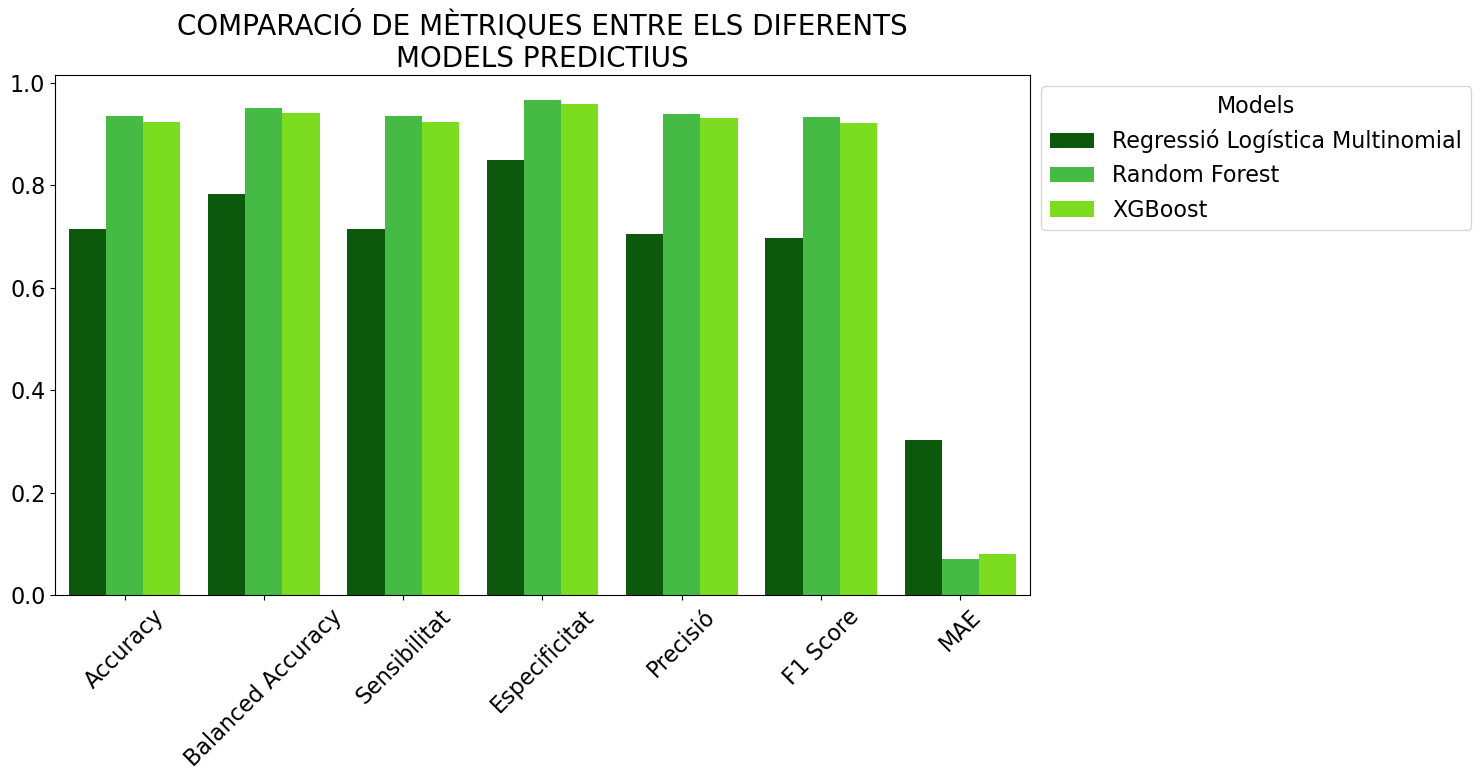

In [39]:
colors1 = {
    'Regressió Logística Multinomial': '#006400',
    'Random Forest': '#32CD32',
    'XGBoost': '#7CFC00',
}

#dades inicials
plt.figure(figsize = (15, 8))
sns.barplot(data=metriques_1, x='Mètrica', y='Valor', hue='Model', palette=colors1)

plt.xlabel("")
plt.ylabel("")
plt.title('COMPARACIÓ DE MÈTRIQUES ENTRE ELS DIFERENTS MODELS\n(No Smote)', fontsize = 18)
plt.legend(title = 'Models', bbox_to_anchor=(1, 1), loc='upper left', fontsize = 16, title_fontsize = 16)
plt.xticks(rotation = 45, fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
plt.show()

#dades equilibrades
plt.figure(figsize = (15, 8))
sns.barplot(data=metriques_2, x='Mètrica', y='Valor', hue='Model', palette=colors1)

plt.xlabel("")
plt.ylabel("")
plt.title('COMPARACIÓ DE MÈTRIQUES ENTRE ELS DIFERENTS\nMODELS PREDICTIUS', fontsize = 20)
plt.legend(title = 'Models', bbox_to_anchor=(1, 1), loc='upper left', fontsize = 16, title_fontsize = 16)
plt.xticks(rotation = 45, fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
plt.show()

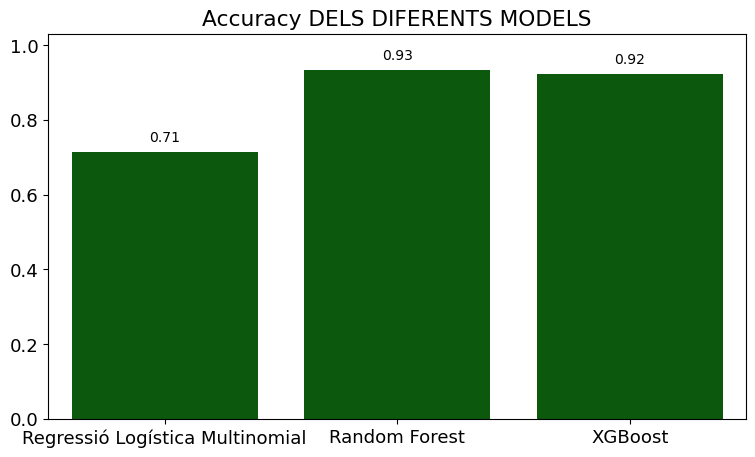

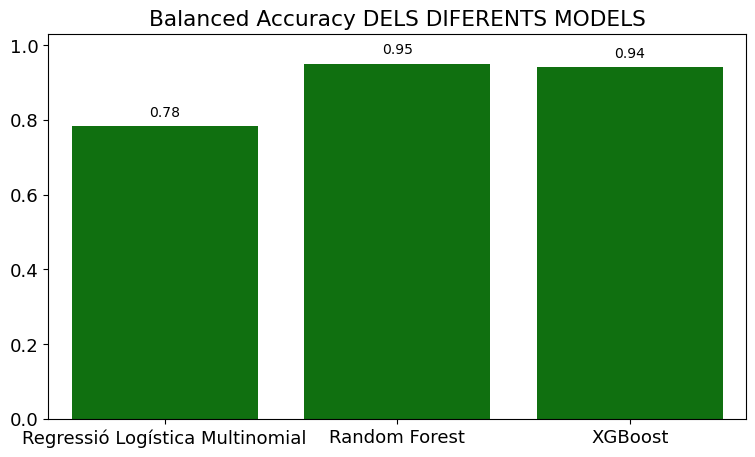

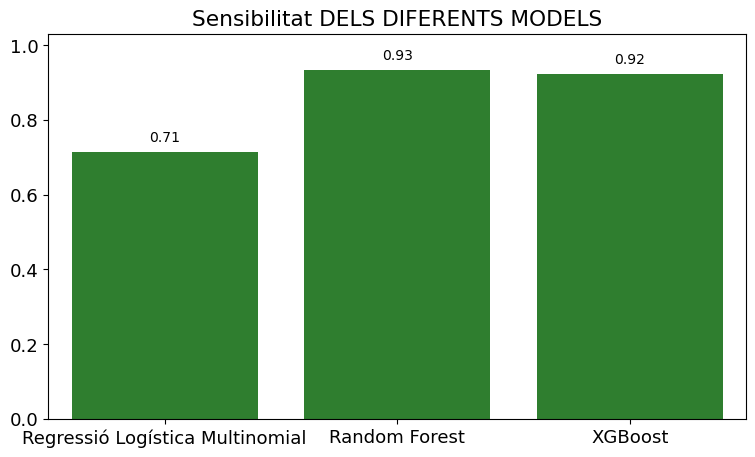

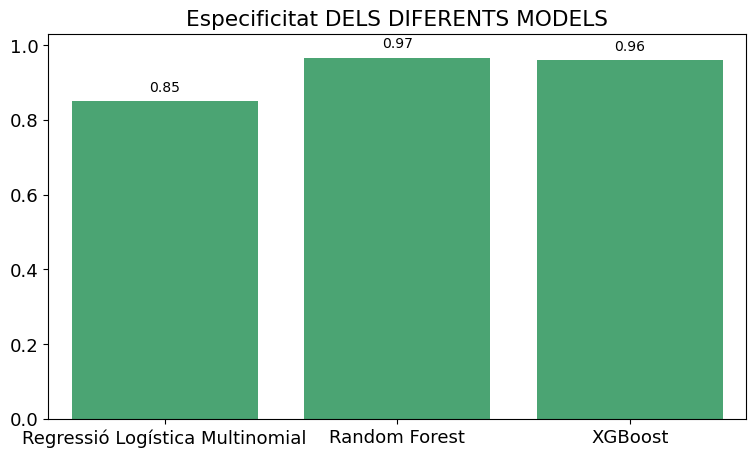

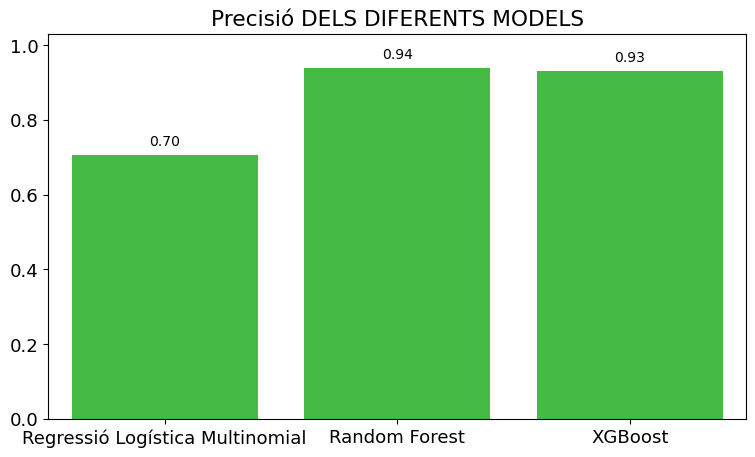

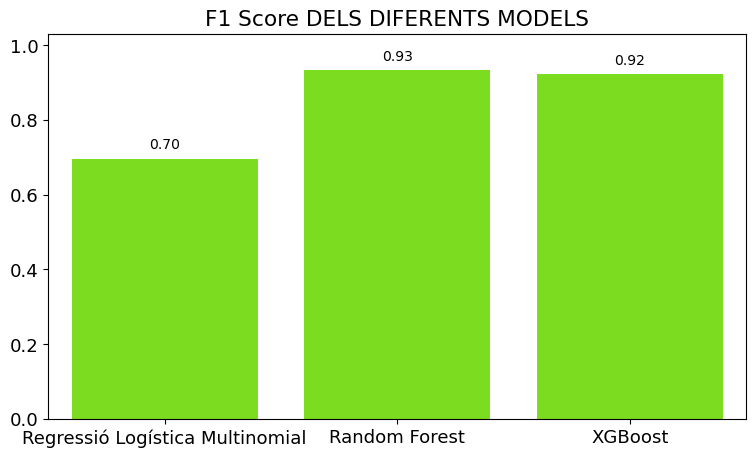

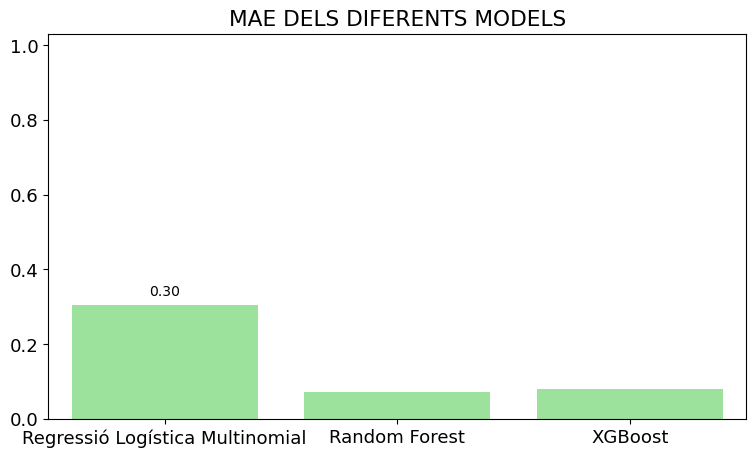

In [25]:
colors = {
    'Accuracy': '#006400',
    'Balanced Accuracy': '#008000',
    'Sensibilitat': '#228B22',
    'Especificitat': '#3CB371',
    'Precisió': '#32CD32',
    'F1 Score': '#7CFC00',
    'MAE': '#90EE90',
    'Temps transcorregut': '#90EE90'
}

noms_metriques = ['Accuracy', 'Balanced Accuracy', 'Sensibilitat', 'Especificitat', 'Precisió', 'F1 Score', 'MAE']

for metrica in noms_metriques:
    plt.figure(figsize = (9, 5))
    ax = sns.barplot(data=metriques_2.loc[metriques_2['Mètrica'] == metrica], x='Model', y='Valor', hue='Mètrica', palette=colors)
    
    for p in ax.patches:
        if p.get_height() > 0.1:
            ax.annotate('{:.2f}'.format(p.get_height()), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), 
                        textcoords='offset points')
    plt.gca().set_ylim([0, 1.03])
    plt.xlabel("")
    plt.ylabel("")
    plt.title(f'{metrica} DELS DIFERENTS MODELS') 
    plt.legend().remove()
    plt.xticks(rotation = 0)
    plt.show()



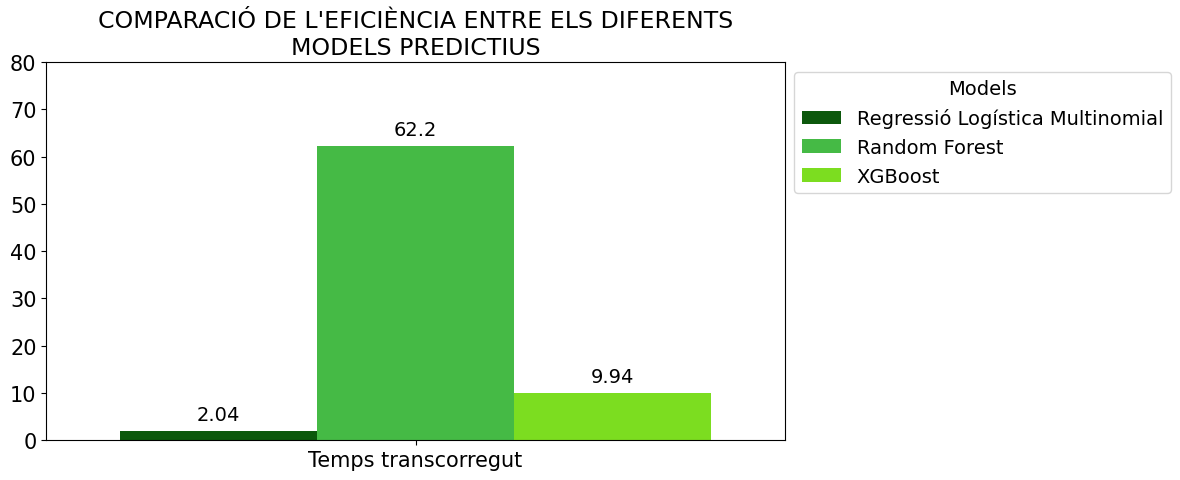

In [33]:
temps = metriques_smote.iloc[:, [0, -1]]
temps = temps.melt(id_vars = 'Model', var_name = 'Eficiència', value_name = 'Valor')

plt.figure(figsize = (12, 5))
sns.barplot(data=temps, x='Eficiència', y='Valor', hue='Model', palette=colors1)

for p in plt.gca().patches:
    if p.get_height() > 0.1:  
        plt.gca().annotate('{}'.format(round(p.get_height(), 2)), 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=14, color='black', xytext=(0, 5), 
                            textcoords='offset points')
plt.gca().set_ylim([0, 40])
plt.xlabel("")
plt.ylabel("")
plt.title('COMPARACIÓ DE L\'EFICIÈNCIA ENTRE ELS DIFERENTS\nMODELS PREDICTIUS', fontsize = 17)
plt.legend(title = 'Models', bbox_to_anchor=(1, 1), loc='upper left', fontsize = 14, title_fontsize = 14)
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(0,80)
plt.tight_layout()
plt.show()